## Project 287– Resume Classification

## Business objective- 
The document classification solution should significantly reduce the manual human effort in the HRM. It should achieve a higher level of accuracy and automation with minimal human intervention


## 1. Import Libraries

In [1]:
# pip install docx2txt

In [2]:
# pip install python-docx

In [3]:
# pip install PyPDF2

In [1]:
import os
import pandas as pd
import docx2txt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import win32com.client
import PyPDF2
from docx import Document

import string
import spacy
import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import word_tokenize

from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
from wordcloud import WordCloud
%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

## 2.	Load and Check Data

In [3]:
# Define the directory path
directory = "C:\\Users\\DELL\\Desktop\\P_287\\Resume"

# Initialize empty lists to store data
categories = []
resumes = []

# Create a COM object to interact with Word
word = win32com.client.Dispatch("Word.Application")
word.Visible = False  # Hide the Word application window

# Walk through the directory and its subfolders
for root, dirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith((".doc", ".docx", ".pdf")):
            # Get the category (subfolder name)
            category = os.path.basename(root)
            
            # Get the full path to the file
            file_path = os.path.join(root, filename)
            
            # Read .docx files
            if filename.endswith(".docx"):
                doc = Document(file_path)
                text = "\n".join([para.text for para in doc.paragraphs])
            
            # Read .doc files
            elif filename.endswith(".doc"):
                doc = word.Documents.Open(file_path)
                text = doc.Content.Text
                doc.Close()
            
            # Read .pdf files
            elif filename.endswith(".pdf"):
                pdf_text = ""
                with open(file_path, "rb") as pdf_file:
                    pdf_reader = PyPDF2.PdfReader(pdf_file)
                    for page_num in range(len(pdf_reader.pages)):
                        page = pdf_reader.pages[page_num]
                        pdf_text += page.extract_text()
                
                text = pdf_text
            
            # Append data to the lists
            categories.append(category)
            resumes.append(text)

# Close the Word application
word.Quit()

# Create a DataFrame
df = pd.DataFrame({'category': categories, 'resume': resumes})

# Display the DataFrame
print(df)

              category                                             resume
0   Peoplesoft resumes    Anubhav Kumar Singh\t\t\n\n  To work in a gl...
1   Peoplesoft resumes  \r\r\r\r\r\r\t\r\rProfile Summary:\t\t\t\t\t\t...
2   Peoplesoft resumes  PeopleSoft Database Administrator\r           ...
3   Peoplesoft resumes  Murali\n\nExperience Summary \n\nI have 6 year...
4   Peoplesoft resumes  Priyanka Ramadoss\r61/46, MountPleasant, \rCoo...
..                 ...                                                ...
74     Workday resumes  \tWorkday Integration Consultant\r\rName      ...
75     Workday resumes  Seeking suitable positions in Workday HCM  as ...
76     Workday resumes  \nWORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nR...
77     Workday resumes  Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...
78     Workday resumes                                                ...

[79 rows x 2 columns]


In [4]:
df.head()

category                                             resume
0  Peoplesoft resumes    Anubhav Kumar Singh\t\t\n\n  To work in a gl...
1  Peoplesoft resumes  \r\r\r\r\r\r\t\r\rProfile Summary:\t\t\t\t\t\t...
2  Peoplesoft resumes  PeopleSoft Database Administrator\r           ...
3  Peoplesoft resumes  Murali\n\nExperience Summary \n\nI have 6 year...
4  Peoplesoft resumes  Priyanka Ramadoss\r61/46, MountPleasant, \rCoo...

In [ ]:
df.tail()

category                                             resume
74  Workday resumes  \tWorkday Integration Consultant\r\rName      ...
75  Workday resumes  Seeking suitable positions in Workday HCM  as ...
76  Workday resumes  \nWORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nR...
77  Workday resumes  Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...
78  Workday resumes                                                ...

In [ ]:
df.shape

(79, 2)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

category    0
resume      0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  79 non-null     object
 1   resume    79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [ ]:
df.describe()

category                                             resume
count                79                                                 79
unique                4                                                 79
top     React Developer    Anubhav Kumar Singh\t\t\n\n  To work in a gl...
freq                 24                                                  1

In [ ]:
df.resume.iloc[1]

'\r\r\r\r\r\r\t\r\rProfile Summary:\t\t\t\t\t\t\t\t\t\t\r7+ years of experience in implementing, upgrading, and supporting PeopleSoft database administration including Human Capital Management (HCM), Financials, Campus Solutions and Portal IHUB\rExpertise in installation, configuration, setup, security and management of the PeopleSoft Internet Architecture PIA environment.\rIn-depth experience in analysis, planning, development, and implementation stages, including load testing, quality assurance, and tuning.\rGained extensive exposure in deploying PeopleSoft Environments.\rExperienced in Troubleshooting PeopleSoft Components.\rSkilled with the capability to analyse & interpret unique problems with a combination of training experience & logical thinking to find the right solutions\r\rCore Competencies:\t\t\t\t\t\t\t\t\t\t\t  \r\rPeopleSoft Implementation. \rTroubleshooting\t PeopleSoft performance issues.                             \rProject /Data Migration        \rInstallation & Con

## 3. Visualization
### 1. Count & Percentage of different Resumes

React Developer       24
Workday resumes       21
Peoplesoft resumes    20
SQL Developer         14
Name: category, dtype: int64


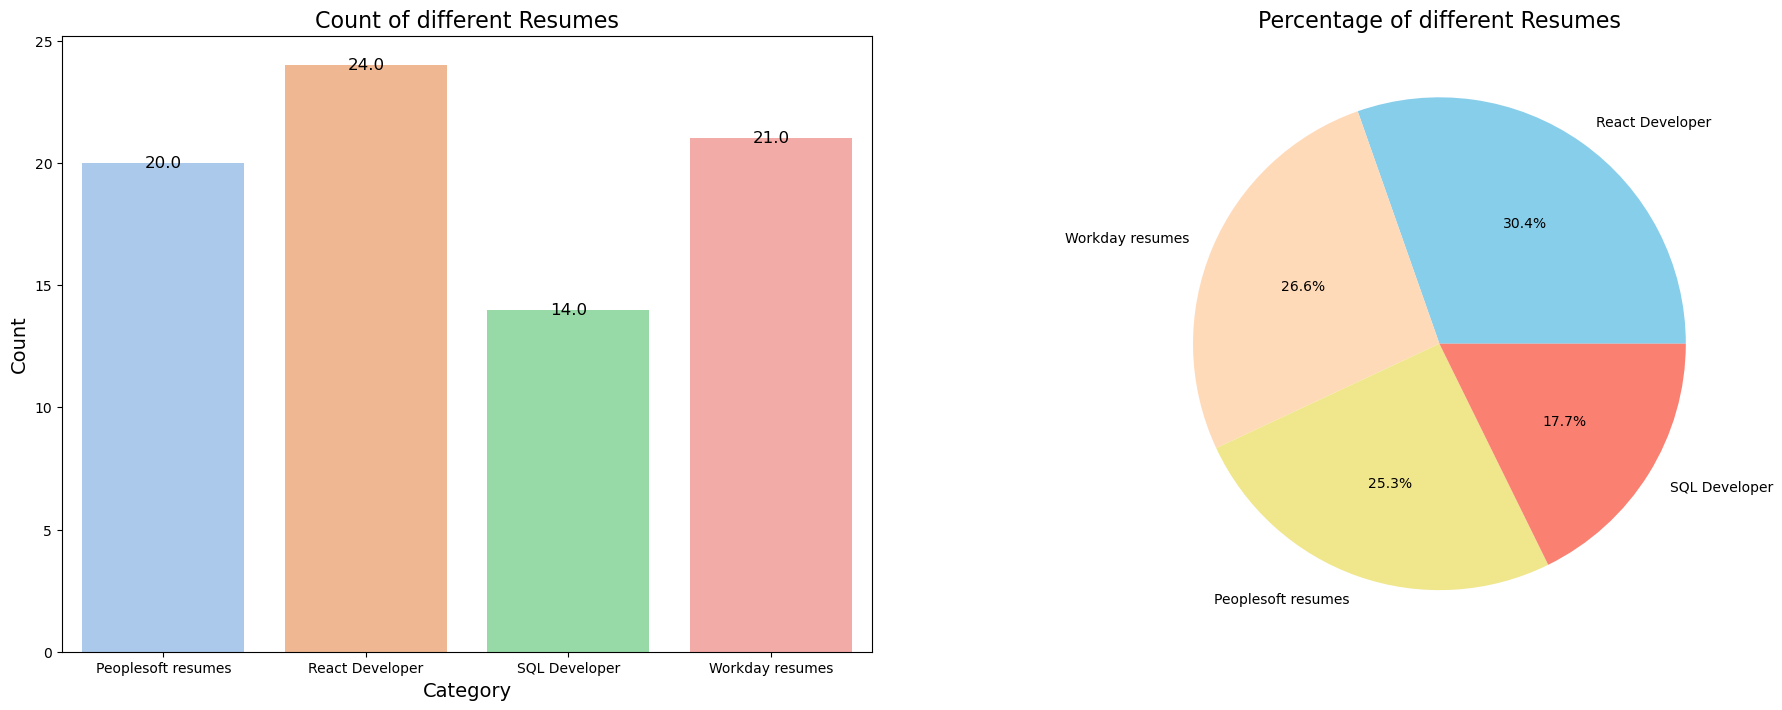

In [15]:
print(df["category"].value_counts())

fig, ax = plt.subplots(1, 2, figsize=(23, 8))

# Count plot
g1 = sns.countplot(x="category", data=df, ax=ax[0], palette="pastel")
g1.set_title("Count of different Resumes", fontsize=16)
g1.set_ylabel("Count", fontsize=14)
g1.set_xlabel("Category", fontsize=14)
for p in g1.patches:
    g1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12)


# Define the explode list (one category exploded, the rest not)
explode = [0.1 if category == "workday resumes" else 0 for category in df["category"].value_counts().index]

# Pie chart
g2 = ax[1].pie(df["category"].value_counts().values,
               explode=explode,  # Use the defined explode list
               labels=df.category.value_counts().index,
               autopct='%1.1f%%',
               colors=['SkyBlue', 'PeachPuff', 'khaki', 'Salmon'])
ax[1].set_title("Percentage of different Resumes", fontsize=16)
# ax[1].legend(df.category.value_counts().index, loc= "upper left", bbox_to_anchor= (0.85, 0.85), fontsize=12) # Set legend fontsize

plt.show()

### 2. Distribution of the resume accoring to category

In [16]:
# Create a new DataFrame with the index as a column
df['S/no'] = df.index

In [17]:
df.set_index("S/no", inplace=True)

In [18]:
df.head(2)

category                                             resume
S/no                                                                       
0     Peoplesoft resumes    Anubhav Kumar Singh\t\t\n\n  To work in a gl...
1     Peoplesoft resumes  \r\r\r\r\r\r\t\r\rProfile Summary:\t\t\t\t\t\t...

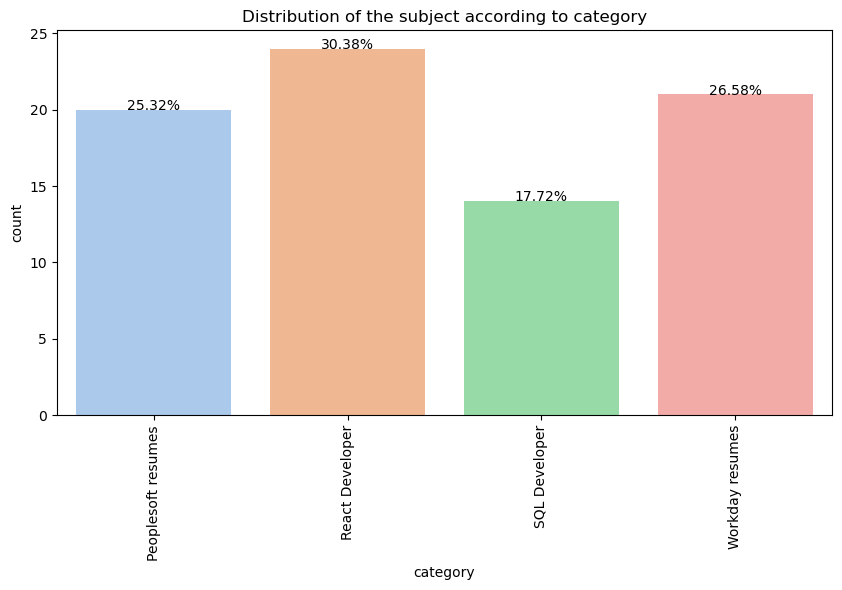

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
plt.figure(figsize=(10, 5))  # Adjust the width and height as needed

ax = sns.countplot(x="category", data=df, palette="pastel")
plt.title("Distribution of the subject according to category")

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Add percentage labels on top of the bars
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center')

plt.show()


##  4. Data Cleaning

In [20]:
first_text =df.resume[10] # This line extracts the value from the 'text' column of the DataFrame 'df' at index 10 (assuming the DataFrame has a column named 'text'). The value at index 10 is assigned to the variable 'first_text.'
first_text

'PeopleSoft Administration\n \nVivekanand Sayana                                                                                                                                                                                                           \t\n\nCareer Objective: \n\nWith my valid expertise of 7.5 years in PeopleSoft, I hope to enhance my skill set while adding value to the business, to enable implementation of solutions, which aid the company’s objectives, understanding and anticipating the needs, interests and motivations of the clients and to deliver on time, budget and to quality, delivering value through improving agility, quality and reliability\n\nProfessional Summary:\n\nOver 7.5 years of experience in PeopleSoft implementation, Support, configuration, migrations, maintenance and administration of Application Server Domains, Process Scheduler Servers, Web Server Domains, PeopleTools Upgrades, Application Updates, PUM, SES and Elastic Search. \nExperience in integrati

### I.	Removal of HTML Contents
•	HTML tags, if present, are removed from the text data.

In [21]:
from bs4 import BeautifulSoup # This line imports the BeautifulSoup class from the bs4 library. BeautifulSoup is a popular library used for parsing HTML and XML documents.

soup = BeautifulSoup(first_text, "html.parser") # This line creates a BeautifulSoup object named soup. It takes two arguments: the HTML content to parse (first_text) and the parser to use ("html.parser" in this case). The parser is used to convert the HTML content into a structured parse tree that makes it easy to navigate and extract data.
first_text= soup.get_text() # This line extracts the text content from the soup object and stores it back in the variable first_text. The get_text() method is used to get the plain text from the parsed HTML, excluding any HTML tags or markup.
first_text # This line likely prints or outputs the value of the variable first_text after extracting the text content from the HTML. The output will be the text without any HTML tags or markup, only the plain text content that was present in the original first_text.

'PeopleSoft Administration\n \nVivekanand Sayana                                                                                                                                                                                                           \t\n\nCareer Objective: \n\nWith my valid expertise of 7.5 years in PeopleSoft, I hope to enhance my skill set while adding value to the business, to enable implementation of solutions, which aid the company’s objectives, understanding and anticipating the needs, interests and motivations of the clients and to deliver on time, budget and to quality, delivering value through improving agility, quality and reliability\n\nProfessional Summary:\n\nOver 7.5 years of experience in PeopleSoft implementation, Support, configuration, migrations, maintenance and administration of Application Server Domains, Process Scheduler Servers, Web Server Domains, PeopleTools Upgrades, Application Updates, PUM, SES and Elastic Search. \nExperience in integrati

### II.	Removal of Punctuation Marks and Special Characters
•	Punctuation marks and special characters are removed from the text data except uppercase/lowercase letters using Regular Expressions

In [22]:
print(first_text)

PeopleSoft Administration
 
Vivekanand Sayana                                                                                                                                                                                                           	

Career Objective: 

With my valid expertise of 7.5 years in PeopleSoft, I hope to enhance my skill set while adding value to the business, to enable implementation of solutions, which aid the company’s objectives, understanding and anticipating the needs, interests and motivations of the clients and to deliver on time, budget and to quality, delivering value through improving agility, quality and reliability

Professional Summary:

Over 7.5 years of experience in PeopleSoft implementation, Support, configuration, migrations, maintenance and administration of Application Server Domains, Process Scheduler Servers, Web Server Domains, PeopleTools Upgrades, Application Updates, PUM, SES and Elastic Search. 
Experience in integration activities

In [23]:
first_text= re.sub('\[[^]]*\]', ' ', first_text) # uses the re.sub() function to remove any text enclosed in square brackets and replace it with a space. The regular expression '\[[^]]*\]' matches any text that is enclosed in square brackets, and the re.sub() function replaces it with a single space. This step is likely used to remove any text that appears within square brackets, such as references, citations, or annotations.
first_text= re.sub('\[^a-zA-Z]', ' ', first_text) # uses the re.sub() function to replace any non-alphabetic characters with spaces. The regular expression [^a-zA-Z] matches any character that is not an uppercase or lowercase letter. The re.sub() function replaces such non-alphabetic characters with spaces. This step is likely used to eliminate special characters, punctuation, numbers, or other symbols from the text, so only alphabetic characters remain.
first_text= first_text.lower() # converts all the remaining text in first_text from uppercase to lowercase. This step is often taken to standardize the text and avoid case sensitivity during further analysis or processing.
first_text # This line likely prints or outputs the value of the variable first_text after the above preprocessing steps have been applied. The output will be the cleaned and lowercased text, which has been processed to remove text in square brackets and replace non-alphabetic characters with spaces.

'peoplesoft administration\n \nvivekanand sayana                                                                                                                                                                                                           \t\n\ncareer objective: \n\nwith my valid expertise of 7.5 years in peoplesoft, i hope to enhance my skill set while adding value to the business, to enable implementation of solutions, which aid the company’s objectives, understanding and anticipating the needs, interests and motivations of the clients and to deliver on time, budget and to quality, delivering value through improving agility, quality and reliability\n\nprofessional summary:\n\nover 7.5 years of experience in peoplesoft implementation, support, configuration, migrations, maintenance and administration of application server domains, process scheduler servers, web server domains, peopletools upgrades, application updates, pum, ses and elastic search. \nexperience in integrati

### III.	Removal of Stopwords
•	Commonly occurring words with little or no significance (stopwords) are removed from the text data like is, a, the...

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
nltk.download("stopwords") # downloads the set of stopwords from the nltk library. Stopwords are common words (e.g., "the," "is," "and") that are often removed from text during text analysis or natural language processing tasks because they do not carry much meaning on their own.
from nltk.corpus import stopwords # imports the 'stopwords' corpus from the nltk library. The 'stopwords' corpus contains a list of common stopwords for various languages.

# we can use tokenize instead of split
first_text= nltk.word_tokenize(first_text) # tokenizes the text in the first_text variable. Tokenization is the process of breaking a text into individual words or tokens. The nltk.word_tokenize() function is used for this purpose. It takes a string of text (first_text) as input and returns a list of tokens (words) from the text.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
first_text= [word for word in first_text if not word in set(stopwords.words("english"))]

In [27]:
print(first_text)

['peoplesoft', 'administration', 'vivekanand', 'sayana', 'career', 'objective', ':', 'valid', 'expertise', '7.5', 'years', 'peoplesoft', ',', 'hope', 'enhance', 'skill', 'set', 'adding', 'value', 'business', ',', 'enable', 'implementation', 'solutions', ',', 'aid', 'company', '’', 'objectives', ',', 'understanding', 'anticipating', 'needs', ',', 'interests', 'motivations', 'clients', 'deliver', 'time', ',', 'budget', 'quality', ',', 'delivering', 'value', 'improving', 'agility', ',', 'quality', 'reliability', 'professional', 'summary', ':', '7.5', 'years', 'experience', 'peoplesoft', 'implementation', ',', 'support', ',', 'configuration', ',', 'migrations', ',', 'maintenance', 'administration', 'application', 'server', 'domains', ',', 'process', 'scheduler', 'servers', ',', 'web', 'server', 'domains', ',', 'peopletools', 'upgrades', ',', 'application', 'updates', ',', 'pum', ',', 'ses', 'elastic', 'search', '.', 'experience', 'integration', 'activities', 'various', 'peoplesoft', 'finan

### IV.	Lemmatization
•	Words are reduced to their base or root form using lemmatization techniques. To bring back multiple form of same word to their common root like 'coming', 'comes' into 'come'.

In [28]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
lemma = nltk.WordNetLemmatizer()
first_text= [lemma.lemmatize(word) for word in first_text]

first_text= " ".join(first_text)
first_text

'peoplesoft administration vivekanand sayana career objective : valid expertise 7.5 year peoplesoft , hope enhance skill set adding value business , enable implementation solution , aid company ’ objective , understanding anticipating need , interest motivation client deliver time , budget quality , delivering value improving agility , quality reliability professional summary : 7.5 year experience peoplesoft implementation , support , configuration , migration , maintenance administration application server domain , process scheduler server , web server domain , peopletools upgrade , application update , pum , s elastic search . experience integration activity various peoplesoft financials , hrms , epm fscm environment . extensively involved resolving performance issue . experience driving infrastructure hardware upgrade , disaster recovery activity . experience health check peoplesoft environment experience peoplesoft database refreshes production development testing environment exper

### V.	Perform it for all the examples
•	The cleaning tasks are applied to all examples in the dataset. We performed the steps for a single example. Now let's perform it for all the examples in the data.

In [30]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

# Download stopwords and punkt data if not already done
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Precompute stopwords set
stop_words = set(stopwords.words('english'))

# Removal of HTML Contents
def remove_html(resume):
    soup = BeautifulSoup(resume, "html.parser")
    return soup.get_text()

# Removal of Punctuation Marks
def remove_punctuations(resume):
    return re.sub(r'\[[^]]*\]', '', resume)

# Removal of Special Characters
def remove_characters(resume):
    return re.sub("[^a-zA-Z]", " ", resume)

# Lemmatization and Removal of Stopwords
def remove_stopwords_and_lemmatization(resume):
    resume = resume.lower()
    words = nltk.word_tokenize(resume)
    lemma = WordNetLemmatizer()
    final_words = [lemma.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(final_words)

# Total function
def cleaning(resume):
    resume = remove_html(resume)
    resume = remove_punctuations(resume)
    resume = remove_characters(resume)
    resume = remove_stopwords_and_lemmatization(resume)
    return resume

# Apply function on text column
df['resume'] = df['resume'].apply(cleaning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
df.head()

category                                             resume
S/no                                                                       
0     Peoplesoft resumes  anubhav kumar singh work globally competitive ...
1     Peoplesoft resumes  profile summary year experience implementing u...
2     Peoplesoft resumes  peoplesoft database administrator gangareddy p...
3     Peoplesoft resumes  murali experience summary year experience work...
4     Peoplesoft resumes  priyanka ramadoss mountpleasant coonoor nilgir...

In [32]:
df.category

S/no
0     Peoplesoft resumes
1     Peoplesoft resumes
2     Peoplesoft resumes
3     Peoplesoft resumes
4     Peoplesoft resumes
             ...        
74       Workday resumes
75       Workday resumes
76       Workday resumes
77       Workday resumes
78       Workday resumes
Name: category, Length: 79, dtype: object

## Visualization on new data
### 1. WordCloud for Peoplesoft resumes

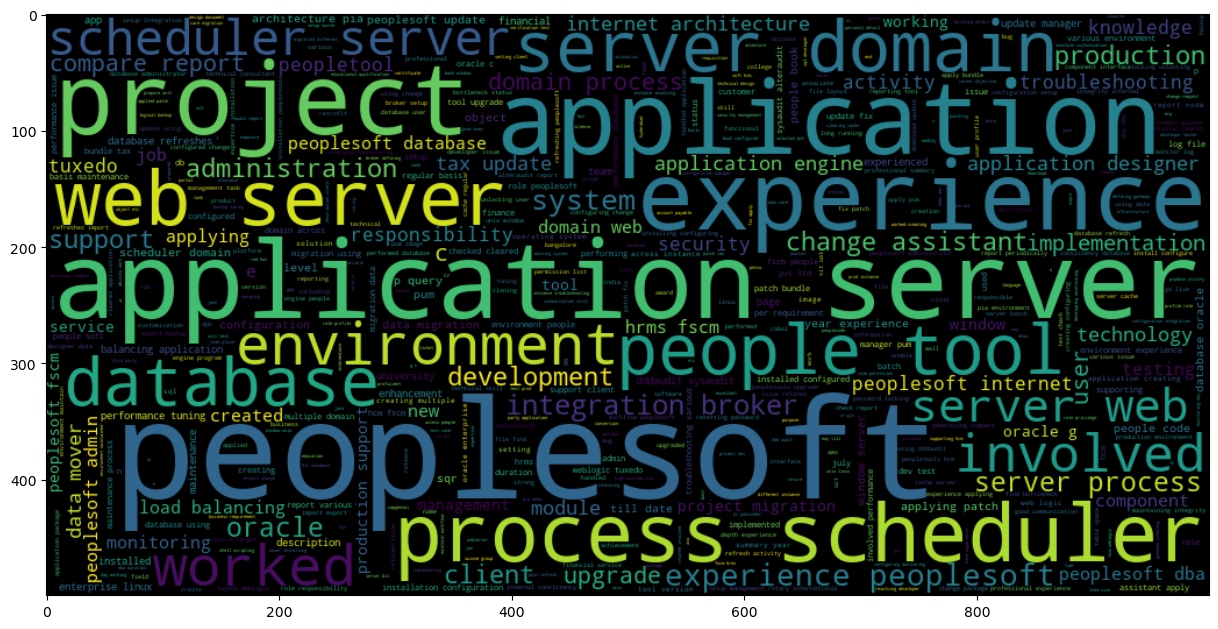

In [33]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(15,15))
wc= WordCloud(max_words= 500, width= 1000, height= 500, stopwords= STOPWORDS).generate(" ".join(df[df.category == 'Peoplesoft resumes'].resume))
plt.imshow(wc, interpolation= 'bilinear')

### 2. WordCloud for workday resumes

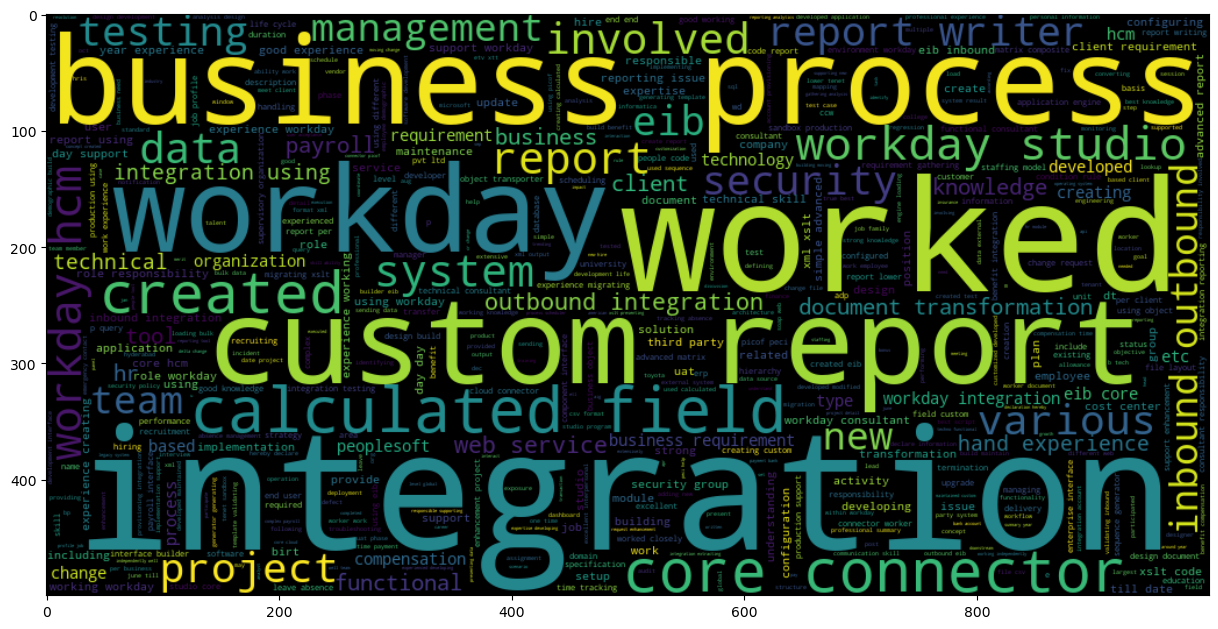

In [34]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(15,15))
wc= WordCloud(max_words= 500, width= 1000, height= 500, stopwords= STOPWORDS).generate(" ".join(df[df.category == 'Workday resumes'].resume))
plt.imshow(wc, interpolation= 'bilinear')

### 3. WordCloud for React Developer resumes

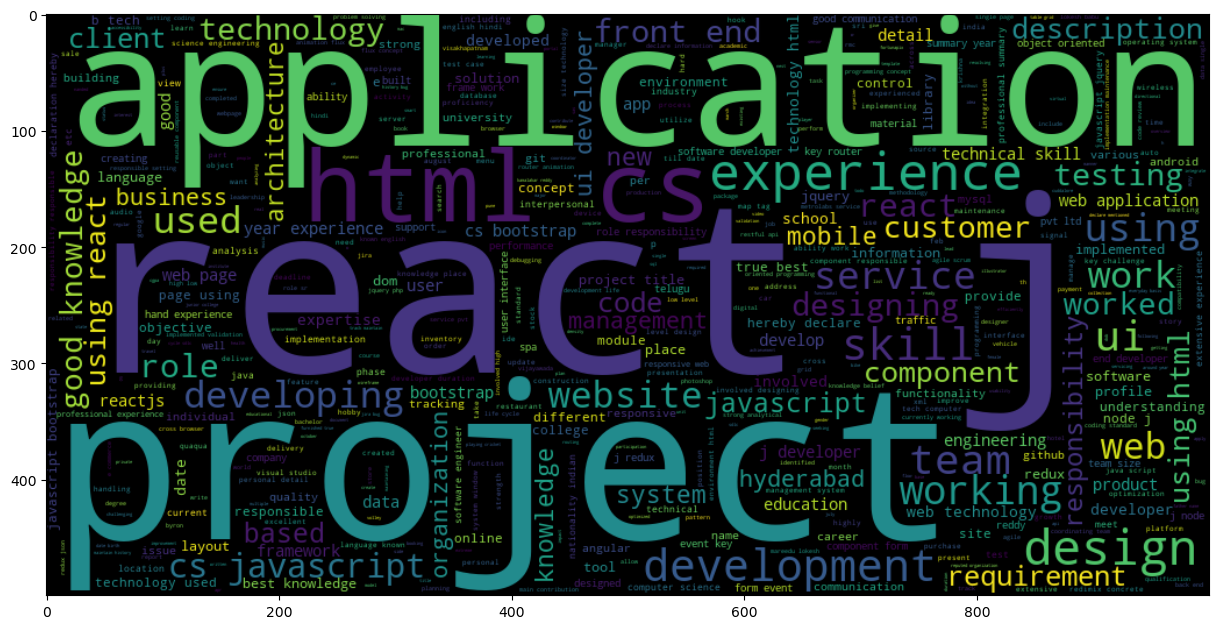

In [35]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(15,15))
wc= WordCloud(max_words= 500, width= 1000, height= 500, stopwords= STOPWORDS).generate(" ".join(df[df.category == 'React Developer'].resume))
plt.imshow(wc, interpolation= 'bilinear')

### 4. WordCloud for SQL Developer Lightning insight resumes

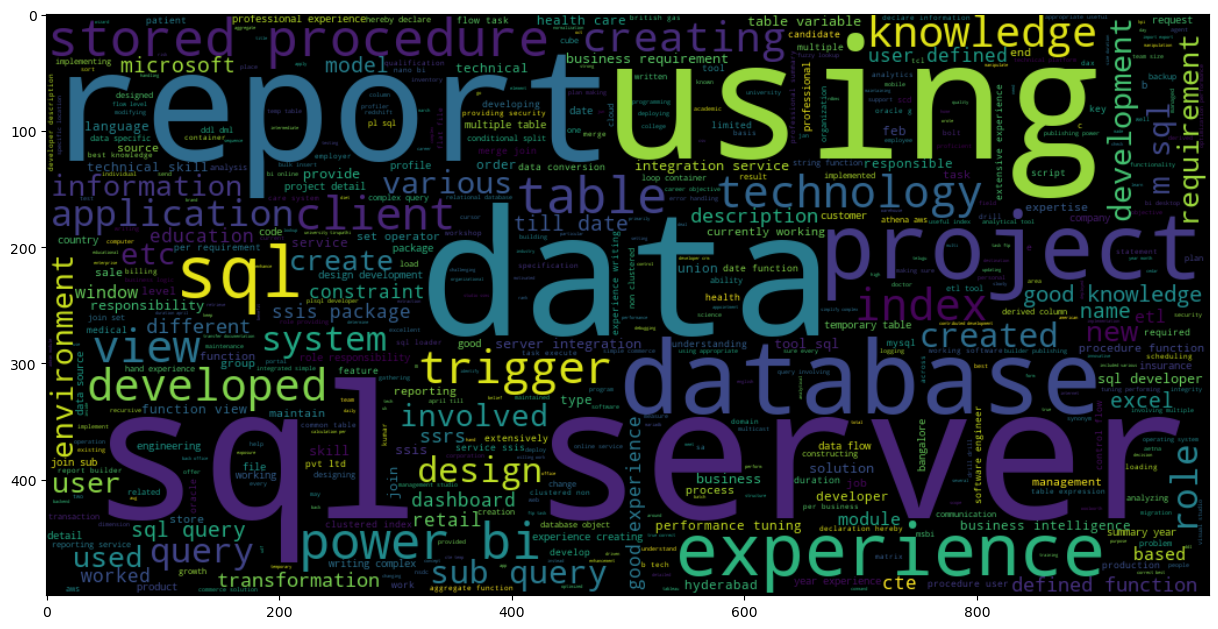

In [36]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(15,15))
wc= WordCloud(max_words= 500, width= 1000, height= 500, stopwords= STOPWORDS).generate(" ".join(df[df.category == 'SQL Developer'].resume))
plt.imshow(wc, interpolation= 'bilinear')

### 5. Number of words in each category of resumes

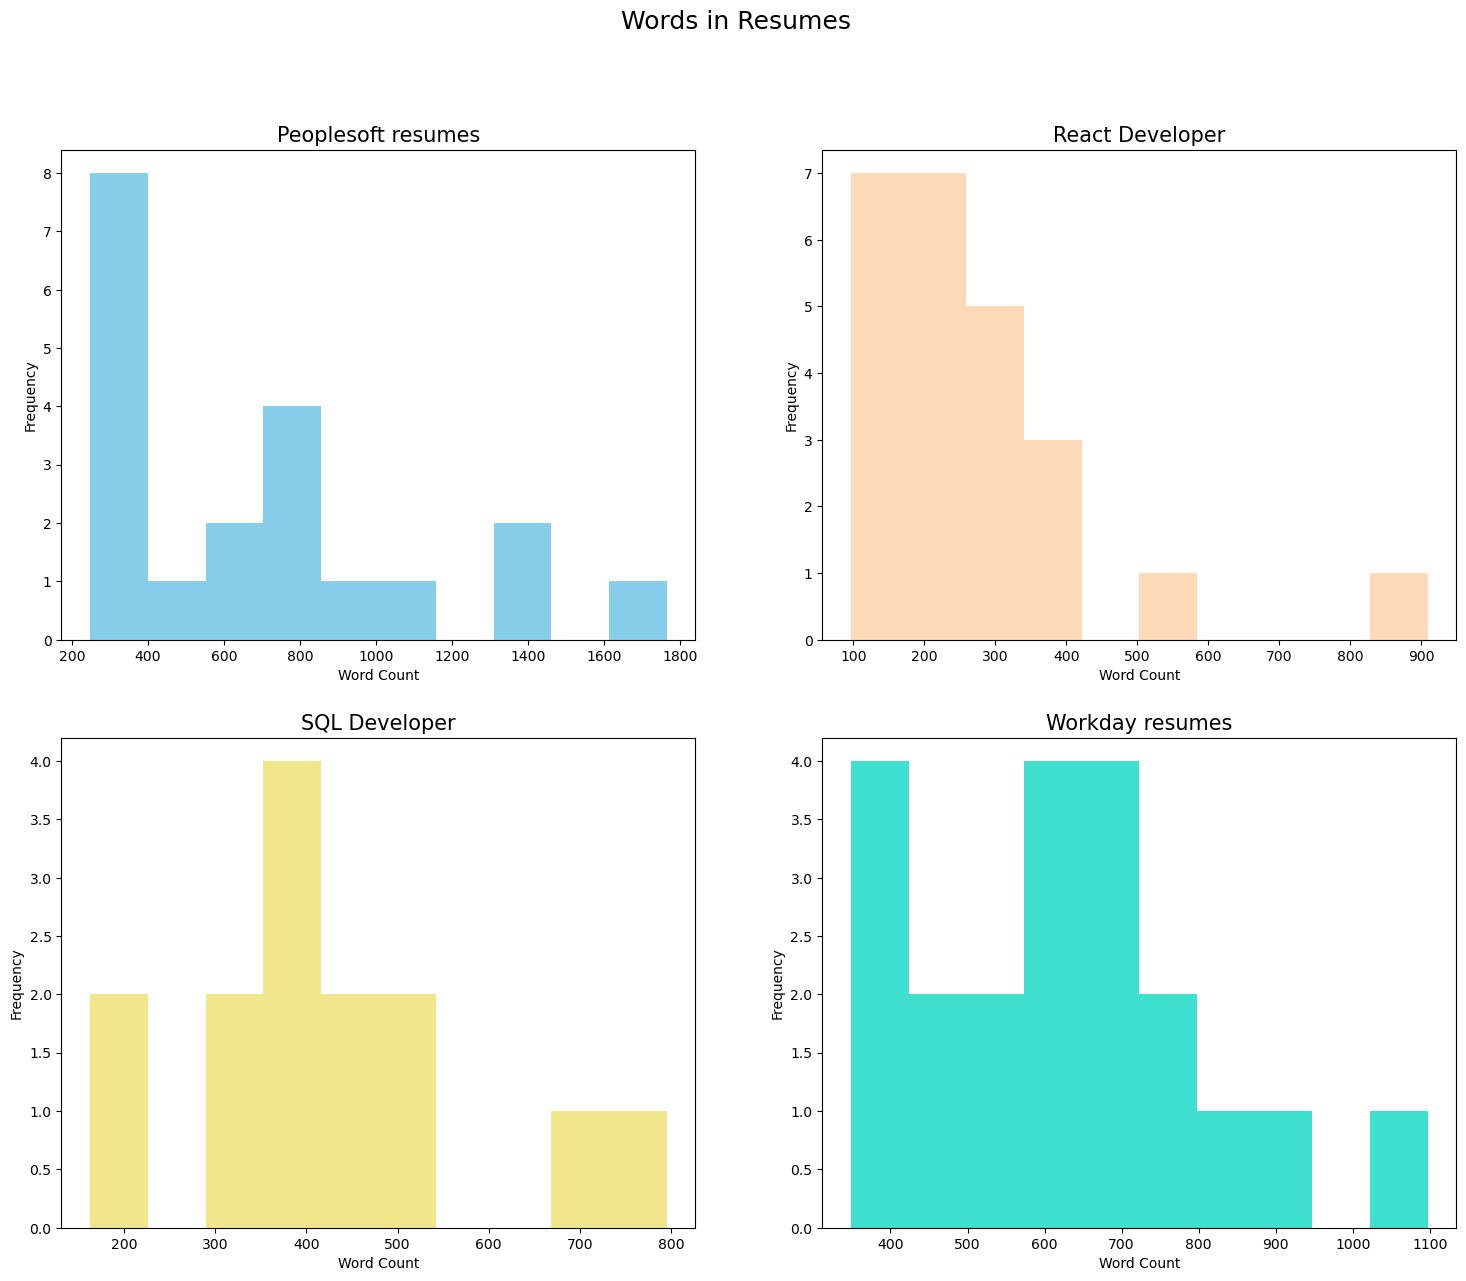

In [37]:
fig,((ax1,ax2),(ax3,ax4))= plt.subplots(2,2, figsize= (18,14))

resume_len= df[df['category']== 'Peoplesoft resumes']['resume'].str.split().map(lambda x: len(x))
ax1.hist(resume_len, color= 'SkyBlue')
ax1.set_title('Peoplesoft resumes', fontsize= 15)
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')

resume_len= df[df['category']== 'React Developer']['resume'].str.split().map(lambda x: len(x))
ax2.hist(resume_len, color= 'PeachPuff')
ax2.set_title('React Developer', fontsize= 15)
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')

resume_len= df[df['category']== 'SQL Developer']['resume'].str.split().map(lambda x: len(x))
ax3.hist(resume_len, color= 'khaki')
ax3.set_title('SQL Developer', fontsize= 15)
ax3.set_xlabel('Word Count')
ax3.set_ylabel('Frequency')

resume_len= df[df['category']== 'Workday resumes']['resume'].str.split().map(lambda x: len(x))
ax4.hist(resume_len, color= 'turquoise')
ax4.set_title('Workday resumes', fontsize= 15)
ax4.set_xlabel('Word Count')
ax4.set_ylabel('Frequency')

fig.suptitle('Words in Resumes', fontsize= 18)
plt.show()

## 5.	N-Gram Analysis
•	This section involves analyzing the text data by breaking it into N-grams, which are contiguous sequences of N items.

In [38]:
resumes = ' '.join(df['resume'])

In [39]:
string = resumes.split(" ")

In [40]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

## I.	Unigram Analysis
•	Analysis is done on single words (individual tokens) in the resume data.


             word  count
0   (experience,)    580
1  (application,)    507
2       (server,)    488
3       (report,)    466
4   (peoplesoft,)    440


<Axes: xlabel='count', ylabel='word'>

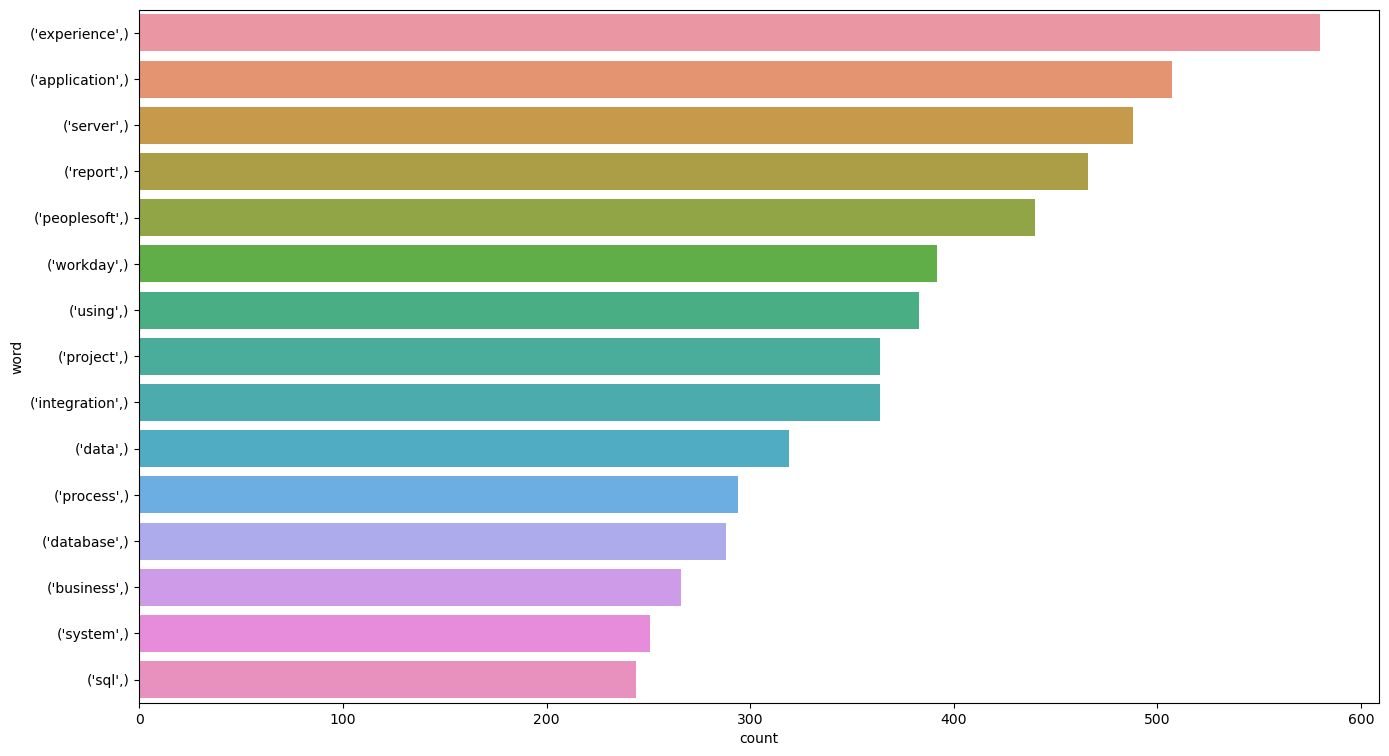

In [41]:
draw_n_gram(string,1)

## II.	Bigram Analysis
•	Analysis is done on pairs of consecutive words in the resume data.


                    word  count
0  (application, server)    122
1   (process, scheduler)    109
2          (sql, server)    105
3          (web, server)     92
4             (react, j)     89


<Axes: xlabel='count', ylabel='word'>

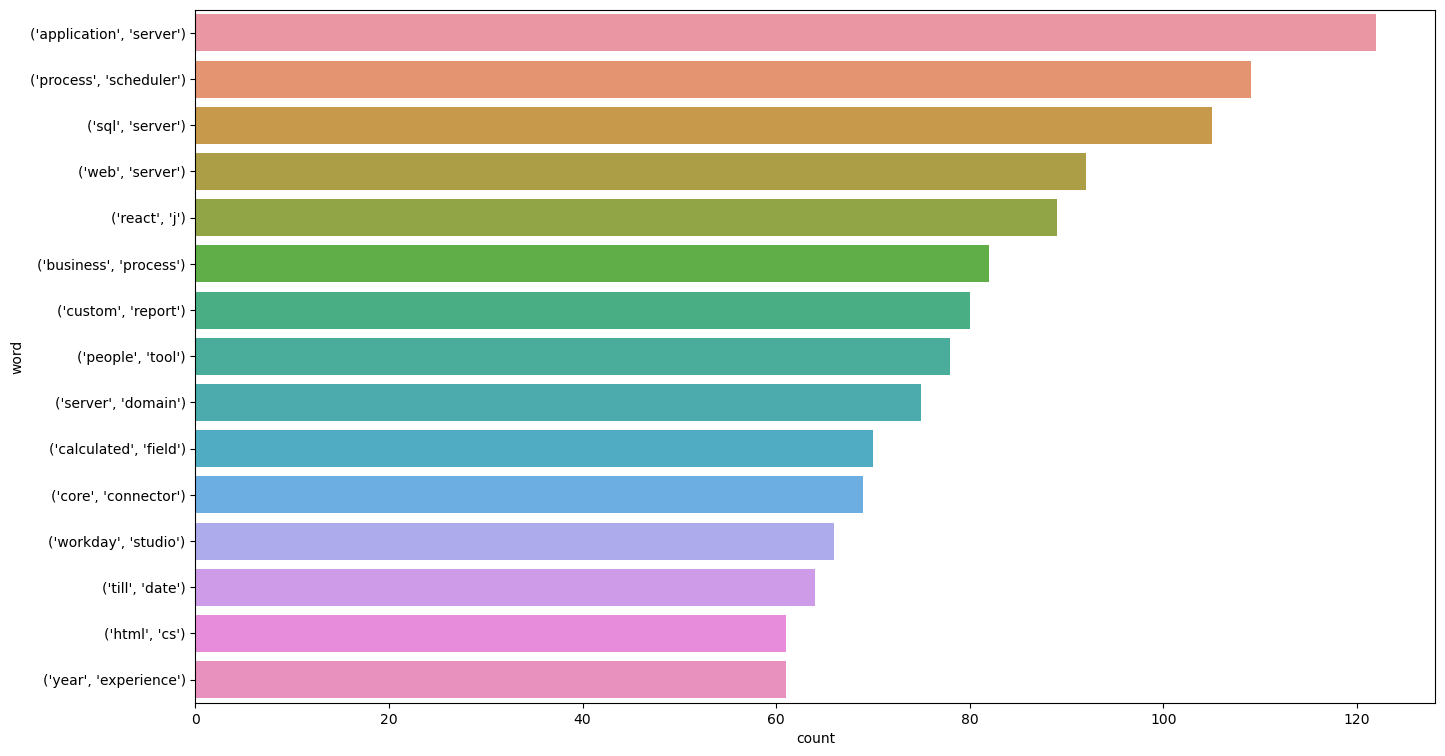

In [42]:
draw_n_gram(string,2)

## III.	Trigram Analysis
•	Analysis is done on triplets of consecutive words in the resume data.

                            word  count
0   (process, scheduler, server)     56
1          (server, web, server)     47
2   (server, process, scheduler)     41
3     (application, server, web)     37
4  (application, server, domain)     37


<Axes: xlabel='count', ylabel='word'>

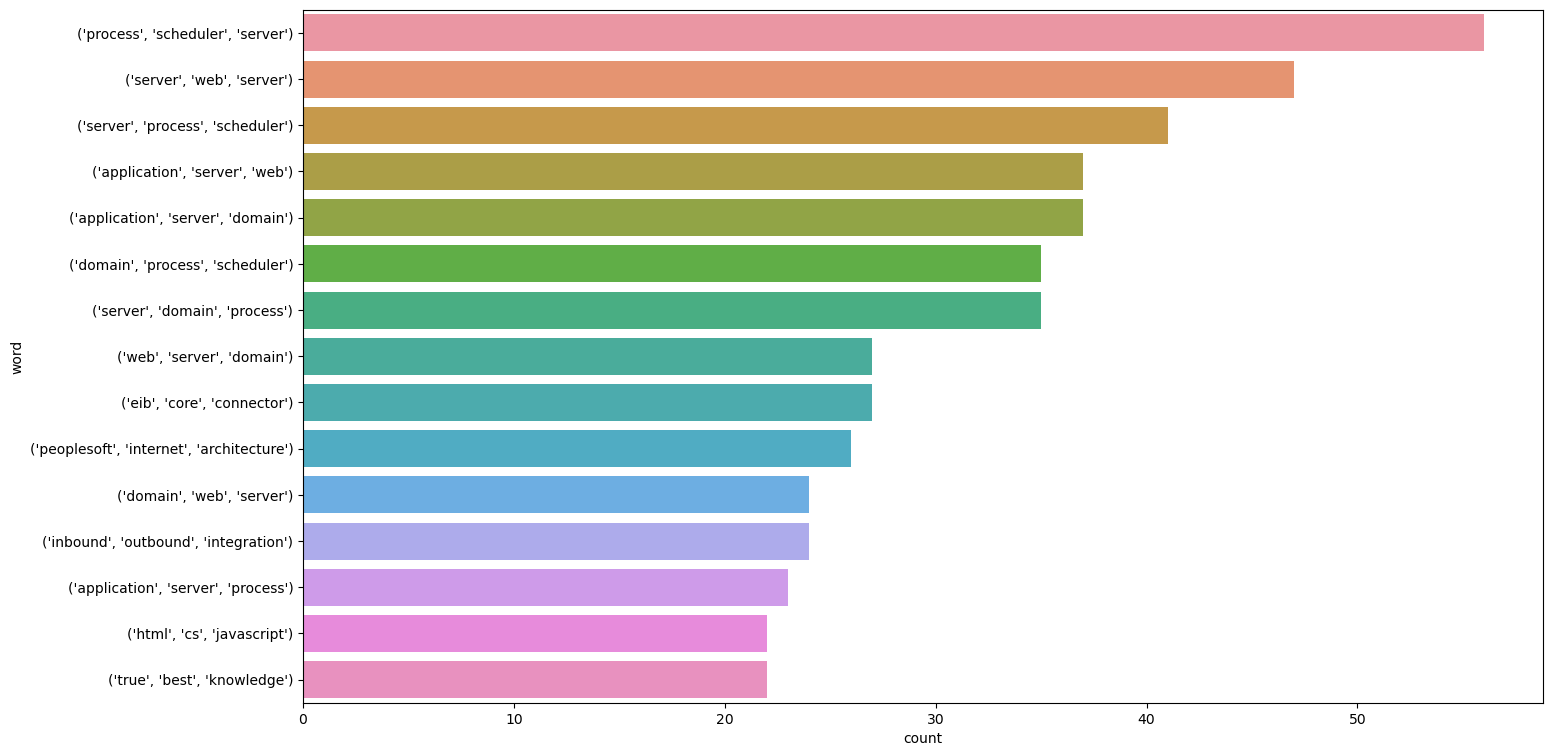

In [43]:
draw_n_gram(string,3)

In [44]:
# Replace text labels with numerical values in the 'category' column
df['category'] = df['category'].replace({
    'Peoplesoft resumes': 0,
    'SQL Developer': 1,
    'Workday resumes': 2,
    'React Developer': 3
})

In [45]:
df

category                                             resume
S/no                                                             
0            0  anubhav kumar singh work globally competitive ...
1            0  profile summary year experience implementing u...
2            0  peoplesoft database administrator gangareddy p...
3            0  murali experience summary year experience work...
4            0  priyanka ramadoss mountpleasant coonoor nilgir...
...        ...                                                ...
74           2  workday integration consultant name sri krishn...
75           2  seeking suitable position workday hcm techno f...
76           2  workday hcm fcm name kumar role workday consul...
77           2  venkateswarlu b workday consultant year experi...
78           2  vinay kumar v workday functional consultant ex...

[79 rows x 2 columns]

## 6. Model Building

## Train Test Split

In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [47]:
requiredText = df['resume'].values
requiredTarget = df['category'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english')
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print ("Feature completed .....")

X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=42, test_size=0.3,
                                                 shuffle=True, stratify=requiredTarget)
print(X_train.shape)
print(X_test.shape)

Feature completed .....
(55, 3806)
(24, 3806)


In [48]:
'''# Convert text data into numerical format using TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')


X = tfidf_vectorizer.fit_transform(df['resume'])
y = df['category']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)'''

"# Convert text data into numerical format using TF-IDF\n# tfidf_vectorizer = TfidfVectorizer(max_features=5000)\ntfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')\n\n\nX = tfidf_vectorizer.fit_transform(df['resume'])\ny = df['category']\n\n# Train-Test Split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)"

## 1. Logistic Regression model

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Use a smaller parameter space for Logistic Regression
param_dist_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression()

# Initialize RandomizedSearchCV for Logistic Regression
random_search_lr = RandomizedSearchCV(lr_model, param_distributions=param_dist_lr, n_iter=10, cv=5, n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV object to the training data
random_search_lr.fit(X_train, y_train)

# Get the best parameters and best estimator from the random search
best_params_lr = random_search_lr.best_params_
best_lr_model = random_search_lr.best_estimator_

# Predict on the test set using the best model
y_pred_lr = best_lr_model.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Test Accuracy:", accuracy_lr)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(conf_matrix_lr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Logistic Regression Test Accuracy: 1.0
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 2. Random Forest

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define an expanded parameter space
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV with more iterations
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the random search
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_

# Predict on the test set using the best model
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Forest Accuracy: 1.0
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 3. SVM

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Initialize the SVM model
svm_model = SVC()

# Define the parameter distributions for random search
param_dist = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Get the best SVM model from the random search
best_svm_model = random_search.best_estimator_

# Predict on the test set using the best model
y_pred_svm = best_svm_model.predict(X_test)

# Evaluate the best SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Test Accuracy:", accuracy_svm)
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix_svm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVM Test Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 4. Neural Network model

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter space for Neural Network
param_dist_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['logistic', 'relu'],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Initialize the Neural Network model
nn_model = MLPClassifier()

# Initialize RandomizedSearchCV for Neural Network
random_search_nn = RandomizedSearchCV(nn_model, param_distributions=param_dist_nn, n_iter=10, cv=5, n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV object to the full training data
random_search_nn.fit(X_train, y_train)

# Get the best parameters and best estimator from the random search
best_params_nn = random_search_nn.best_params_
best_nn_model = random_search_nn.best_estimator_

# Predict on the test set using the best model
y_pred_nn = best_nn_model.predict(X_test)

# Evaluate the Neural Network model
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("Neural Network Test Accuracy:", accuracy_nn)

print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
print("Confusion Matrix:")
print(conf_matrix_nn)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Neural Network Test Accuracy: 1.0
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 5. Multinomial Naive Bayes

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define hyperparameter distributions for Naive Bayes
nb_param_dist = {
    'alpha': [0.1, 1.0, 10.0]
}

# Initialize Naive Bayes classifier
nb_classifier = MultinomialNB()

# Create a RandomizedSearchCV object for hyperparameter tuning
random_search_nb = RandomizedSearchCV(nb_classifier, param_distributions=nb_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV object to the full training data
random_search_nb.fit(X_train, y_train)

# Get the best Naive Bayes classifier from the random search
best_nb_classifier = random_search_nb.best_estimator_

# Predictions using the best estimator
nb_y_pred = best_nb_classifier.predict(X_test)

# Calculate accuracy
nb_test_accuracy = accuracy_score(y_test, nb_y_pred)
print("Naive Bayes Test Accuracy:", nb_test_accuracy)

# Print classification report
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_y_pred))

# Confusion Matrix
nb_conf_matrix = confusion_matrix(y_test, nb_y_pred)
print("Naive Bayes Confusion Matrix:")
print(nb_conf_matrix)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes Test Accuracy: 1.0
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Naive Bayes Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 6. Gradient Boosting

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define hyperparameter distributions for Gradient Boosting
gb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Create a RandomizedSearchCV object for hyperparameter tuning
random_search_gb = RandomizedSearchCV(gb_classifier, param_distributions=gb_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV object to the full training data
random_search_gb.fit(X_train, y_train)

# Get the best Gradient Boosting classifier from the random search
best_gb_classifier = random_search_gb.best_estimator_

# Predictions using the best estimator
gb_y_pred = best_gb_classifier.predict(X_test)

# Calculate accuracy
gb_test_accuracy = accuracy_score(y_test, gb_y_pred)
print("Gradient Boosting Test Accuracy:", gb_test_accuracy)

# Print classification report
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_y_pred))

# Confusion Matrix
gb_conf_matrix = confusion_matrix(y_test, gb_y_pred)
print("Gradient Boosting Confusion Matrix:")
print(gb_conf_matrix)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Gradient Boosting Test Accuracy: 1.0
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Gradient Boosting Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 7. Ridge Classifier model

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Use a smaller parameter space for Ridge Classifier
param_dist_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Initialize the Ridge Classifier model
ridge_model = RidgeClassifier()

# Initialize RandomizedSearchCV for Ridge Classifier
random_search_ridge = RandomizedSearchCV(ridge_model, param_distributions=param_dist_ridge, n_iter=10, cv=5, n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV object to the full training data
random_search_ridge.fit(X_train, y_train)

# Get the best parameters and best estimator from the random search
best_params_ridge = random_search_ridge.best_params_
best_ridge_model = random_search_ridge.best_estimator_

# Predict on the test set using the best model
y_pred_ridge = best_ridge_model.predict(X_test)

# Evaluate the Ridge Classifier model
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
print("Ridge Classifier Test Accuracy:", accuracy_ridge)

print("Ridge Classifier Classification Report:")
print(classification_report(y_test, y_pred_ridge))

conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)
print("Confusion Matrix:")
print(conf_matrix_ridge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Ridge Classifier Test Accuracy: 1.0
Ridge Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 8. KNN classifier

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier()

# Cross-validation
cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Fit the KNN classifier on the training data
knn_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_knn = knn_classifier.predict(X_test)

# Calculate accuracy on test data
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Test Accuracy:", accuracy_knn)

# Classification report
classification_rep = classification_report(y_test, y_pred_knn)
print("KNN Classification Report:")
print(classification_rep)

# Confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:")
print(conf_matrix_knn)

Cross-Validation Scores: [1.         0.72727273 0.90909091 1.         1.        ]
Mean CV Score: 0.9272727272727274
Standard Deviation of CV Scores: 0.10601730717900545
KNN Test Accuracy: 1.0
KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 9. CatBoost classifier

In [57]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Initialize the CatBoost classifier
catboost_classifier = CatBoostClassifier()

# Cross-validation
cv_scores = cross_val_score(catboost_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy Score:", cv_scores.mean())
print("Standard Deviation of CV Accuracy Scores:", cv_scores.std())

# Fit the CatBoost classifier on the training data
catboost_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_catboost = catboost_classifier.predict(X_test)

# Calculate accuracy on the test data
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("CatBoost Test Accuracy:", accuracy_catboost)

# Classification report
classification_rep = classification_report(y_test, y_pred_catboost)
print("CatBoost Classification Report:")
print(classification_rep)

# Confusion matrix
conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)
print("Confusion Matrix:")
print(conf_matrix_catboost)

Learning rate set to 0.067474
0:	learn: 1.3651830	total: 230ms	remaining: 3m 50s
1:	learn: 1.3347730	total: 301ms	remaining: 2m 29s
2:	learn: 1.3090653	total: 373ms	remaining: 2m 3s
3:	learn: 1.2820698	total: 446ms	remaining: 1m 50s
4:	learn: 1.2456626	total: 517ms	remaining: 1m 42s
5:	learn: 1.2014051	total: 586ms	remaining: 1m 37s
6:	learn: 1.1718456	total: 659ms	remaining: 1m 33s
7:	learn: 1.1423841	total: 731ms	remaining: 1m 30s
8:	learn: 1.0822083	total: 775ms	remaining: 1m 25s
9:	learn: 1.0558490	total: 846ms	remaining: 1m 23s
10:	learn: 1.0342024	total: 919ms	remaining: 1m 22s
11:	learn: 1.0035107	total: 1s	remaining: 1m 22s
12:	learn: 0.9770506	total: 1.1s	remaining: 1m 23s
13:	learn: 0.9604411	total: 1.2s	remaining: 1m 24s
14:	learn: 0.9377599	total: 1.28s	remaining: 1m 23s
15:	learn: 0.9141388	total: 1.35s	remaining: 1m 23s
16:	learn: 0.8857780	total: 1.43s	remaining: 1m 22s
17:	learn: 0.8715702	total: 1.5s	remaining: 1m 22s
18:	learn: 0.8589701	total: 1.57s	remaining: 1m 21s

160:	learn: 0.0651663	total: 11.7s	remaining: 1m
161:	learn: 0.0645530	total: 11.8s	remaining: 1m
162:	learn: 0.0640530	total: 11.8s	remaining: 1m
163:	learn: 0.0636300	total: 11.9s	remaining: 1m
164:	learn: 0.0629701	total: 12s	remaining: 1m
165:	learn: 0.0623926	total: 12.1s	remaining: 1m
166:	learn: 0.0618997	total: 12.1s	remaining: 1m
167:	learn: 0.0614917	total: 12.2s	remaining: 1m
168:	learn: 0.0608930	total: 12.3s	remaining: 1m
169:	learn: 0.0604038	total: 12.3s	remaining: 1m
170:	learn: 0.0599151	total: 12.4s	remaining: 1m
171:	learn: 0.0594186	total: 12.5s	remaining: 1m
172:	learn: 0.0588846	total: 12.6s	remaining: 1m
173:	learn: 0.0584520	total: 12.6s	remaining: 60s
174:	learn: 0.0578386	total: 12.7s	remaining: 59.9s
175:	learn: 0.0573402	total: 12.8s	remaining: 59.8s
176:	learn: 0.0570102	total: 12.8s	remaining: 59.7s
177:	learn: 0.0565997	total: 12.9s	remaining: 59.7s
178:	learn: 0.0560957	total: 13s	remaining: 59.6s
179:	learn: 0.0557297	total: 13.1s	remaining: 59.5s
180:	

320:	learn: 0.0258549	total: 22.9s	remaining: 48.5s
321:	learn: 0.0257697	total: 23s	remaining: 48.4s
322:	learn: 0.0256562	total: 23s	remaining: 48.3s
323:	learn: 0.0255406	total: 23.1s	remaining: 48.2s
324:	learn: 0.0254120	total: 23.2s	remaining: 48.2s
325:	learn: 0.0253019	total: 23.3s	remaining: 48.1s
326:	learn: 0.0252314	total: 23.3s	remaining: 48s
327:	learn: 0.0251387	total: 23.4s	remaining: 48s
328:	learn: 0.0250610	total: 23.5s	remaining: 47.9s
329:	learn: 0.0249711	total: 23.6s	remaining: 47.8s
330:	learn: 0.0248945	total: 23.6s	remaining: 47.7s
331:	learn: 0.0248027	total: 23.7s	remaining: 47.7s
332:	learn: 0.0247229	total: 23.8s	remaining: 47.6s
333:	learn: 0.0246582	total: 23.8s	remaining: 47.5s
334:	learn: 0.0245743	total: 23.9s	remaining: 47.5s
335:	learn: 0.0244386	total: 24s	remaining: 47.4s
336:	learn: 0.0243502	total: 24s	remaining: 47.3s
337:	learn: 0.0242795	total: 24.1s	remaining: 47.2s
338:	learn: 0.0242217	total: 24.2s	remaining: 47.1s
339:	learn: 0.0241518	to

481:	learn: 0.0160731	total: 34.6s	remaining: 37.2s
482:	learn: 0.0160385	total: 34.7s	remaining: 37.1s
483:	learn: 0.0159974	total: 34.7s	remaining: 37s
484:	learn: 0.0159577	total: 34.8s	remaining: 37s
485:	learn: 0.0159218	total: 34.9s	remaining: 36.9s
486:	learn: 0.0158796	total: 34.9s	remaining: 36.8s
487:	learn: 0.0158381	total: 35s	remaining: 36.7s
488:	learn: 0.0157802	total: 35.1s	remaining: 36.6s
489:	learn: 0.0157346	total: 35.1s	remaining: 36.6s
490:	learn: 0.0157042	total: 35.2s	remaining: 36.5s
491:	learn: 0.0156616	total: 35.3s	remaining: 36.4s
492:	learn: 0.0156196	total: 35.4s	remaining: 36.4s
493:	learn: 0.0155772	total: 35.5s	remaining: 36.3s
494:	learn: 0.0155515	total: 35.5s	remaining: 36.3s
495:	learn: 0.0155003	total: 35.6s	remaining: 36.2s
496:	learn: 0.0154627	total: 35.7s	remaining: 36.1s
497:	learn: 0.0154148	total: 35.8s	remaining: 36.1s
498:	learn: 0.0153778	total: 35.8s	remaining: 36s
499:	learn: 0.0153437	total: 35.9s	remaining: 35.9s
500:	learn: 0.015302

642:	learn: 0.0114720	total: 46.1s	remaining: 25.6s
643:	learn: 0.0114561	total: 46.2s	remaining: 25.5s
644:	learn: 0.0114295	total: 46.2s	remaining: 25.4s
645:	learn: 0.0114185	total: 46.3s	remaining: 25.4s
646:	learn: 0.0114064	total: 46.4s	remaining: 25.3s
647:	learn: 0.0113885	total: 46.5s	remaining: 25.3s
648:	learn: 0.0113569	total: 46.6s	remaining: 25.2s
649:	learn: 0.0113397	total: 46.6s	remaining: 25.1s
650:	learn: 0.0113211	total: 46.7s	remaining: 25s
651:	learn: 0.0113071	total: 46.8s	remaining: 25s
652:	learn: 0.0112891	total: 46.9s	remaining: 24.9s
653:	learn: 0.0112728	total: 46.9s	remaining: 24.8s
654:	learn: 0.0112552	total: 47s	remaining: 24.8s
655:	learn: 0.0112289	total: 47.1s	remaining: 24.7s
656:	learn: 0.0112133	total: 47.1s	remaining: 24.6s
657:	learn: 0.0111963	total: 47.2s	remaining: 24.5s
658:	learn: 0.0111835	total: 47.3s	remaining: 24.5s
659:	learn: 0.0111662	total: 47.4s	remaining: 24.4s
660:	learn: 0.0111491	total: 47.4s	remaining: 24.3s
661:	learn: 0.0111

802:	learn: 0.0090263	total: 57.7s	remaining: 14.1s
803:	learn: 0.0090133	total: 57.7s	remaining: 14.1s
804:	learn: 0.0090018	total: 57.8s	remaining: 14s
805:	learn: 0.0089921	total: 57.9s	remaining: 13.9s
806:	learn: 0.0089778	total: 58s	remaining: 13.9s
807:	learn: 0.0089614	total: 58s	remaining: 13.8s
808:	learn: 0.0089469	total: 58.1s	remaining: 13.7s
809:	learn: 0.0089289	total: 58.2s	remaining: 13.6s
810:	learn: 0.0089118	total: 58.2s	remaining: 13.6s
811:	learn: 0.0089001	total: 58.3s	remaining: 13.5s
812:	learn: 0.0088875	total: 58.4s	remaining: 13.4s
813:	learn: 0.0088753	total: 58.5s	remaining: 13.4s
814:	learn: 0.0088640	total: 58.6s	remaining: 13.3s
815:	learn: 0.0088555	total: 58.6s	remaining: 13.2s
816:	learn: 0.0088457	total: 58.7s	remaining: 13.2s
817:	learn: 0.0088315	total: 58.8s	remaining: 13.1s
818:	learn: 0.0088193	total: 58.9s	remaining: 13s
819:	learn: 0.0088104	total: 58.9s	remaining: 12.9s
820:	learn: 0.0087977	total: 59s	remaining: 12.9s
821:	learn: 0.0087886	

961:	learn: 0.0073694	total: 1m 9s	remaining: 2.73s
962:	learn: 0.0073594	total: 1m 9s	remaining: 2.66s
963:	learn: 0.0073527	total: 1m 9s	remaining: 2.59s
964:	learn: 0.0073407	total: 1m 9s	remaining: 2.52s
965:	learn: 0.0073312	total: 1m 9s	remaining: 2.44s
966:	learn: 0.0073241	total: 1m 9s	remaining: 2.37s
967:	learn: 0.0073164	total: 1m 9s	remaining: 2.3s
968:	learn: 0.0073095	total: 1m 9s	remaining: 2.23s
969:	learn: 0.0073015	total: 1m 9s	remaining: 2.16s
970:	learn: 0.0072936	total: 1m 9s	remaining: 2.09s
971:	learn: 0.0072861	total: 1m 9s	remaining: 2.01s
972:	learn: 0.0072794	total: 1m 10s	remaining: 1.94s
973:	learn: 0.0072738	total: 1m 10s	remaining: 1.87s
974:	learn: 0.0072659	total: 1m 10s	remaining: 1.8s
975:	learn: 0.0072583	total: 1m 10s	remaining: 1.73s
976:	learn: 0.0072517	total: 1m 10s	remaining: 1.66s
977:	learn: 0.0072446	total: 1m 10s	remaining: 1.58s
978:	learn: 0.0072362	total: 1m 10s	remaining: 1.51s
979:	learn: 0.0072248	total: 1m 10s	remaining: 1.44s
980:	l

121:	learn: 0.1058471	total: 9s	remaining: 1m 4s
122:	learn: 0.1041902	total: 9.07s	remaining: 1m 4s
123:	learn: 0.1027030	total: 9.14s	remaining: 1m 4s
124:	learn: 0.1013418	total: 9.22s	remaining: 1m 4s
125:	learn: 0.1001944	total: 9.29s	remaining: 1m 4s
126:	learn: 0.0991855	total: 9.36s	remaining: 1m 4s
127:	learn: 0.0978183	total: 9.43s	remaining: 1m 4s
128:	learn: 0.0968549	total: 9.5s	remaining: 1m 4s
129:	learn: 0.0957625	total: 9.58s	remaining: 1m 4s
130:	learn: 0.0946598	total: 9.65s	remaining: 1m 4s
131:	learn: 0.0934014	total: 9.72s	remaining: 1m 3s
132:	learn: 0.0922934	total: 9.79s	remaining: 1m 3s
133:	learn: 0.0916134	total: 9.87s	remaining: 1m 3s
134:	learn: 0.0906643	total: 9.94s	remaining: 1m 3s
135:	learn: 0.0897281	total: 10s	remaining: 1m 3s
136:	learn: 0.0887921	total: 10.1s	remaining: 1m 3s
137:	learn: 0.0880382	total: 10.2s	remaining: 1m 3s
138:	learn: 0.0872109	total: 10.2s	remaining: 1m 3s
139:	learn: 0.0865167	total: 10.3s	remaining: 1m 3s
140:	learn: 0.0853

281:	learn: 0.0340673	total: 20.9s	remaining: 53.2s
282:	learn: 0.0338887	total: 21s	remaining: 53.2s
283:	learn: 0.0337743	total: 21.1s	remaining: 53.1s
284:	learn: 0.0336474	total: 21.1s	remaining: 53.1s
285:	learn: 0.0335185	total: 21.2s	remaining: 53s
286:	learn: 0.0333453	total: 21.3s	remaining: 52.9s
287:	learn: 0.0331674	total: 21.4s	remaining: 52.9s
288:	learn: 0.0330304	total: 21.5s	remaining: 52.8s
289:	learn: 0.0328417	total: 21.5s	remaining: 52.7s
290:	learn: 0.0326972	total: 21.6s	remaining: 52.6s
291:	learn: 0.0325188	total: 21.7s	remaining: 52.5s
292:	learn: 0.0324254	total: 21.7s	remaining: 52.5s
293:	learn: 0.0323200	total: 21.8s	remaining: 52.4s
294:	learn: 0.0321944	total: 21.9s	remaining: 52.4s
295:	learn: 0.0320596	total: 22s	remaining: 52.3s
296:	learn: 0.0319172	total: 22.1s	remaining: 52.3s
297:	learn: 0.0317694	total: 22.1s	remaining: 52.2s
298:	learn: 0.0316623	total: 22.2s	remaining: 52.1s
299:	learn: 0.0315583	total: 22.3s	remaining: 52s
300:	learn: 0.031475

442:	learn: 0.0199492	total: 32.9s	remaining: 41.4s
443:	learn: 0.0199045	total: 33s	remaining: 41.3s
444:	learn: 0.0198688	total: 33.1s	remaining: 41.3s
445:	learn: 0.0197964	total: 33.2s	remaining: 41.2s
446:	learn: 0.0197206	total: 33.2s	remaining: 41.1s
447:	learn: 0.0196771	total: 33.3s	remaining: 41s
448:	learn: 0.0196262	total: 33.4s	remaining: 41s
449:	learn: 0.0195664	total: 33.4s	remaining: 40.9s
450:	learn: 0.0195095	total: 33.5s	remaining: 40.8s
451:	learn: 0.0194660	total: 33.6s	remaining: 40.7s
452:	learn: 0.0194172	total: 33.7s	remaining: 40.7s
453:	learn: 0.0193614	total: 33.7s	remaining: 40.6s
454:	learn: 0.0193125	total: 33.8s	remaining: 40.5s
455:	learn: 0.0192428	total: 33.9s	remaining: 40.4s
456:	learn: 0.0191884	total: 34s	remaining: 40.3s
457:	learn: 0.0191570	total: 34s	remaining: 40.3s
458:	learn: 0.0191013	total: 34.1s	remaining: 40.2s
459:	learn: 0.0190283	total: 34.2s	remaining: 40.1s
460:	learn: 0.0189952	total: 34.2s	remaining: 40s
461:	learn: 0.0189621	to

603:	learn: 0.0140240	total: 44.8s	remaining: 29.4s
604:	learn: 0.0139908	total: 44.9s	remaining: 29.3s
605:	learn: 0.0139549	total: 45s	remaining: 29.3s
606:	learn: 0.0139209	total: 45.1s	remaining: 29.2s
607:	learn: 0.0138825	total: 45.1s	remaining: 29.1s
608:	learn: 0.0138544	total: 45.2s	remaining: 29s
609:	learn: 0.0138338	total: 45.3s	remaining: 28.9s
610:	learn: 0.0138098	total: 45.3s	remaining: 28.9s
611:	learn: 0.0137922	total: 45.4s	remaining: 28.8s
612:	learn: 0.0137602	total: 45.5s	remaining: 28.7s
613:	learn: 0.0137336	total: 45.5s	remaining: 28.6s
614:	learn: 0.0136924	total: 45.6s	remaining: 28.5s
615:	learn: 0.0136599	total: 45.7s	remaining: 28.5s
616:	learn: 0.0136384	total: 45.7s	remaining: 28.4s
617:	learn: 0.0136109	total: 45.8s	remaining: 28.3s
618:	learn: 0.0135834	total: 45.9s	remaining: 28.2s
619:	learn: 0.0135571	total: 45.9s	remaining: 28.2s
620:	learn: 0.0135234	total: 46s	remaining: 28.1s
621:	learn: 0.0134967	total: 46.1s	remaining: 28s
622:	learn: 0.013470

763:	learn: 0.0106321	total: 56.2s	remaining: 17.4s
764:	learn: 0.0106183	total: 56.3s	remaining: 17.3s
765:	learn: 0.0106034	total: 56.4s	remaining: 17.2s
766:	learn: 0.0105916	total: 56.5s	remaining: 17.2s
767:	learn: 0.0105810	total: 56.5s	remaining: 17.1s
768:	learn: 0.0105562	total: 56.6s	remaining: 17s
769:	learn: 0.0105354	total: 56.7s	remaining: 16.9s
770:	learn: 0.0105157	total: 56.7s	remaining: 16.8s
771:	learn: 0.0105045	total: 56.8s	remaining: 16.8s
772:	learn: 0.0104809	total: 56.9s	remaining: 16.7s
773:	learn: 0.0104709	total: 56.9s	remaining: 16.6s
774:	learn: 0.0104572	total: 57s	remaining: 16.6s
775:	learn: 0.0104462	total: 57.1s	remaining: 16.5s
776:	learn: 0.0104224	total: 57.1s	remaining: 16.4s
777:	learn: 0.0104094	total: 57.2s	remaining: 16.3s
778:	learn: 0.0103996	total: 57.3s	remaining: 16.3s
779:	learn: 0.0103913	total: 57.4s	remaining: 16.2s
780:	learn: 0.0103729	total: 57.4s	remaining: 16.1s
781:	learn: 0.0103627	total: 57.5s	remaining: 16s
782:	learn: 0.0103

924:	learn: 0.0086013	total: 1m 8s	remaining: 5.52s
925:	learn: 0.0085925	total: 1m 8s	remaining: 5.45s
926:	learn: 0.0085834	total: 1m 8s	remaining: 5.38s
927:	learn: 0.0085772	total: 1m 8s	remaining: 5.3s
928:	learn: 0.0085674	total: 1m 8s	remaining: 5.23s
929:	learn: 0.0085596	total: 1m 8s	remaining: 5.16s
930:	learn: 0.0085484	total: 1m 8s	remaining: 5.08s
931:	learn: 0.0085368	total: 1m 8s	remaining: 5.01s
932:	learn: 0.0085257	total: 1m 8s	remaining: 4.94s
933:	learn: 0.0085145	total: 1m 8s	remaining: 4.86s
934:	learn: 0.0085065	total: 1m 8s	remaining: 4.79s
935:	learn: 0.0084956	total: 1m 8s	remaining: 4.71s
936:	learn: 0.0084904	total: 1m 9s	remaining: 4.64s
937:	learn: 0.0084787	total: 1m 9s	remaining: 4.57s
938:	learn: 0.0084684	total: 1m 9s	remaining: 4.49s
939:	learn: 0.0084589	total: 1m 9s	remaining: 4.42s
940:	learn: 0.0084477	total: 1m 9s	remaining: 4.35s
941:	learn: 0.0084337	total: 1m 9s	remaining: 4.27s
942:	learn: 0.0084282	total: 1m 9s	remaining: 4.2s
943:	learn: 0.

81:	learn: 0.2153153	total: 6.05s	remaining: 1m 7s
82:	learn: 0.2116879	total: 6.12s	remaining: 1m 7s
83:	learn: 0.2080690	total: 6.2s	remaining: 1m 7s
84:	learn: 0.2026944	total: 6.24s	remaining: 1m 7s
85:	learn: 0.1991115	total: 6.32s	remaining: 1m 7s
86:	learn: 0.1940025	total: 6.39s	remaining: 1m 7s
87:	learn: 0.1898740	total: 6.47s	remaining: 1m 7s
88:	learn: 0.1853298	total: 6.55s	remaining: 1m 7s
89:	learn: 0.1818443	total: 6.63s	remaining: 1m 7s
90:	learn: 0.1777585	total: 6.71s	remaining: 1m 6s
91:	learn: 0.1752421	total: 6.78s	remaining: 1m 6s
92:	learn: 0.1726046	total: 6.86s	remaining: 1m 6s
93:	learn: 0.1698491	total: 6.93s	remaining: 1m 6s
94:	learn: 0.1672356	total: 7s	remaining: 1m 6s
95:	learn: 0.1634565	total: 7.07s	remaining: 1m 6s
96:	learn: 0.1599677	total: 7.14s	remaining: 1m 6s
97:	learn: 0.1566143	total: 7.21s	remaining: 1m 6s
98:	learn: 0.1527936	total: 7.24s	remaining: 1m 5s
99:	learn: 0.1491959	total: 7.28s	remaining: 1m 5s
100:	learn: 0.1460400	total: 7.35s	

241:	learn: 0.0374310	total: 17.5s	remaining: 54.7s
242:	learn: 0.0372742	total: 17.5s	remaining: 54.6s
243:	learn: 0.0371001	total: 17.6s	remaining: 54.6s
244:	learn: 0.0369214	total: 17.7s	remaining: 54.5s
245:	learn: 0.0367199	total: 17.8s	remaining: 54.4s
246:	learn: 0.0365729	total: 17.8s	remaining: 54.3s
247:	learn: 0.0363631	total: 17.9s	remaining: 54.2s
248:	learn: 0.0362093	total: 17.9s	remaining: 54.1s
249:	learn: 0.0359880	total: 18s	remaining: 54s
250:	learn: 0.0357989	total: 18.1s	remaining: 54s
251:	learn: 0.0355899	total: 18.2s	remaining: 53.9s
252:	learn: 0.0353629	total: 18.2s	remaining: 53.8s
253:	learn: 0.0351240	total: 18.3s	remaining: 53.7s
254:	learn: 0.0349333	total: 18.3s	remaining: 53.6s
255:	learn: 0.0347617	total: 18.4s	remaining: 53.4s
256:	learn: 0.0345511	total: 18.5s	remaining: 53.4s
257:	learn: 0.0343198	total: 18.5s	remaining: 53.3s
258:	learn: 0.0341826	total: 18.6s	remaining: 53.3s
259:	learn: 0.0340229	total: 18.7s	remaining: 53.2s
260:	learn: 0.0338

400:	learn: 0.0189184	total: 28.1s	remaining: 41.9s
401:	learn: 0.0188496	total: 28.1s	remaining: 41.9s
402:	learn: 0.0187712	total: 28.2s	remaining: 41.8s
403:	learn: 0.0187148	total: 28.3s	remaining: 41.7s
404:	learn: 0.0186461	total: 28.3s	remaining: 41.6s
405:	learn: 0.0186018	total: 28.4s	remaining: 41.6s
406:	learn: 0.0185510	total: 28.5s	remaining: 41.5s
407:	learn: 0.0184958	total: 28.6s	remaining: 41.4s
408:	learn: 0.0184287	total: 28.6s	remaining: 41.4s
409:	learn: 0.0183264	total: 28.7s	remaining: 41.2s
410:	learn: 0.0182842	total: 28.7s	remaining: 41.2s
411:	learn: 0.0182223	total: 28.8s	remaining: 41.1s
412:	learn: 0.0181624	total: 28.8s	remaining: 41s
413:	learn: 0.0181056	total: 28.9s	remaining: 40.9s
414:	learn: 0.0180424	total: 29s	remaining: 40.9s
415:	learn: 0.0179977	total: 29.1s	remaining: 40.8s
416:	learn: 0.0179119	total: 29.1s	remaining: 40.7s
417:	learn: 0.0178689	total: 29.2s	remaining: 40.6s
418:	learn: 0.0178103	total: 29.3s	remaining: 40.6s
419:	learn: 0.01

560:	learn: 0.0124720	total: 38.9s	remaining: 30.4s
561:	learn: 0.0124562	total: 38.9s	remaining: 30.3s
562:	learn: 0.0124216	total: 39s	remaining: 30.3s
563:	learn: 0.0123965	total: 39.1s	remaining: 30.2s
564:	learn: 0.0123722	total: 39.1s	remaining: 30.1s
565:	learn: 0.0123536	total: 39.2s	remaining: 30.1s
566:	learn: 0.0123202	total: 39.3s	remaining: 30s
567:	learn: 0.0122952	total: 39.3s	remaining: 29.9s
568:	learn: 0.0122737	total: 39.5s	remaining: 29.9s
569:	learn: 0.0122547	total: 39.5s	remaining: 29.8s
570:	learn: 0.0122336	total: 39.6s	remaining: 29.7s
571:	learn: 0.0121992	total: 39.6s	remaining: 29.7s
572:	learn: 0.0121851	total: 39.7s	remaining: 29.6s
573:	learn: 0.0121567	total: 39.8s	remaining: 29.5s
574:	learn: 0.0121388	total: 39.9s	remaining: 29.5s
575:	learn: 0.0121132	total: 39.9s	remaining: 29.4s
576:	learn: 0.0120876	total: 40s	remaining: 29.3s
577:	learn: 0.0120419	total: 40s	remaining: 29.2s
578:	learn: 0.0120222	total: 40.1s	remaining: 29.1s
579:	learn: 0.011989

719:	learn: 0.0092474	total: 49.4s	remaining: 19.2s
720:	learn: 0.0092331	total: 49.4s	remaining: 19.1s
721:	learn: 0.0092202	total: 49.5s	remaining: 19.1s
722:	learn: 0.0092100	total: 49.6s	remaining: 19s
723:	learn: 0.0091921	total: 49.7s	remaining: 18.9s
724:	learn: 0.0091756	total: 49.7s	remaining: 18.9s
725:	learn: 0.0091658	total: 49.8s	remaining: 18.8s
726:	learn: 0.0091390	total: 49.8s	remaining: 18.7s
727:	learn: 0.0091233	total: 49.9s	remaining: 18.6s
728:	learn: 0.0091127	total: 50s	remaining: 18.6s
729:	learn: 0.0090999	total: 50s	remaining: 18.5s
730:	learn: 0.0090886	total: 50.1s	remaining: 18.4s
731:	learn: 0.0090758	total: 50.2s	remaining: 18.4s
732:	learn: 0.0090496	total: 50.2s	remaining: 18.3s
733:	learn: 0.0090264	total: 50.2s	remaining: 18.2s
734:	learn: 0.0090079	total: 50.3s	remaining: 18.1s
735:	learn: 0.0089876	total: 50.4s	remaining: 18.1s
736:	learn: 0.0089729	total: 50.4s	remaining: 18s
737:	learn: 0.0089547	total: 50.5s	remaining: 17.9s
738:	learn: 0.008942

879:	learn: 0.0073397	total: 1m	remaining: 8.22s
880:	learn: 0.0073315	total: 1m	remaining: 8.15s
881:	learn: 0.0073170	total: 1m	remaining: 8.08s
882:	learn: 0.0073076	total: 1m	remaining: 8.01s
883:	learn: 0.0072974	total: 1m	remaining: 7.94s
884:	learn: 0.0072882	total: 1m	remaining: 7.87s
885:	learn: 0.0072787	total: 1m	remaining: 7.8s
886:	learn: 0.0072710	total: 1m	remaining: 7.73s
887:	learn: 0.0072625	total: 1m	remaining: 7.67s
888:	learn: 0.0072548	total: 1m	remaining: 7.6s
889:	learn: 0.0072491	total: 1m	remaining: 7.53s
890:	learn: 0.0072398	total: 1m	remaining: 7.46s
891:	learn: 0.0072282	total: 1m 1s	remaining: 7.39s
892:	learn: 0.0072228	total: 1m 1s	remaining: 7.32s
893:	learn: 0.0072141	total: 1m 1s	remaining: 7.26s
894:	learn: 0.0072036	total: 1m 1s	remaining: 7.19s
895:	learn: 0.0071970	total: 1m 1s	remaining: 7.12s
896:	learn: 0.0071850	total: 1m 1s	remaining: 7.05s
897:	learn: 0.0071745	total: 1m 1s	remaining: 6.98s
898:	learn: 0.0071655	total: 1m 1s	remaining: 6.92

39:	learn: 0.5549328	total: 2.96s	remaining: 1m 11s
40:	learn: 0.5425528	total: 3.03s	remaining: 1m 10s
41:	learn: 0.5343598	total: 3.1s	remaining: 1m 10s
42:	learn: 0.5297571	total: 3.17s	remaining: 1m 10s
43:	learn: 0.5218711	total: 3.23s	remaining: 1m 10s
44:	learn: 0.5122932	total: 3.3s	remaining: 1m 10s
45:	learn: 0.5050627	total: 3.37s	remaining: 1m 9s
46:	learn: 0.4949564	total: 3.44s	remaining: 1m 9s
47:	learn: 0.4850083	total: 3.51s	remaining: 1m 9s
48:	learn: 0.4728063	total: 3.59s	remaining: 1m 9s
49:	learn: 0.4586832	total: 3.66s	remaining: 1m 9s
50:	learn: 0.4505650	total: 3.73s	remaining: 1m 9s
51:	learn: 0.4394186	total: 3.8s	remaining: 1m 9s
52:	learn: 0.4299335	total: 3.87s	remaining: 1m 9s
53:	learn: 0.4217469	total: 3.94s	remaining: 1m 9s
54:	learn: 0.4105769	total: 4.01s	remaining: 1m 8s
55:	learn: 0.3994679	total: 4.08s	remaining: 1m 8s
56:	learn: 0.3922716	total: 4.16s	remaining: 1m 8s
57:	learn: 0.3819572	total: 4.22s	remaining: 1m 8s
58:	learn: 0.3748192	total: 

199:	learn: 0.0564100	total: 14.4s	remaining: 57.6s
200:	learn: 0.0561229	total: 14.5s	remaining: 57.5s
201:	learn: 0.0556495	total: 14.5s	remaining: 57.4s
202:	learn: 0.0551422	total: 14.6s	remaining: 57.3s
203:	learn: 0.0546998	total: 14.7s	remaining: 57.2s
204:	learn: 0.0543088	total: 14.7s	remaining: 57.1s
205:	learn: 0.0538729	total: 14.8s	remaining: 57s
206:	learn: 0.0535152	total: 14.9s	remaining: 57s
207:	learn: 0.0531803	total: 14.9s	remaining: 56.9s
208:	learn: 0.0528856	total: 15s	remaining: 56.8s
209:	learn: 0.0525016	total: 15.1s	remaining: 56.7s
210:	learn: 0.0521802	total: 15.2s	remaining: 56.7s
211:	learn: 0.0518646	total: 15.2s	remaining: 56.6s
212:	learn: 0.0516536	total: 15.3s	remaining: 56.5s
213:	learn: 0.0512404	total: 15.4s	remaining: 56.4s
214:	learn: 0.0509382	total: 15.4s	remaining: 56.3s
215:	learn: 0.0505743	total: 15.5s	remaining: 56.2s
216:	learn: 0.0501696	total: 15.5s	remaining: 56.1s
217:	learn: 0.0496884	total: 15.6s	remaining: 55.9s
218:	learn: 0.0492

358:	learn: 0.0252996	total: 26.3s	remaining: 47s
359:	learn: 0.0252347	total: 26.4s	remaining: 46.9s
360:	learn: 0.0251446	total: 26.4s	remaining: 46.8s
361:	learn: 0.0250455	total: 26.5s	remaining: 46.7s
362:	learn: 0.0249597	total: 26.6s	remaining: 46.6s
363:	learn: 0.0248813	total: 26.6s	remaining: 46.5s
364:	learn: 0.0247817	total: 26.7s	remaining: 46.5s
365:	learn: 0.0246769	total: 26.8s	remaining: 46.4s
366:	learn: 0.0246117	total: 26.8s	remaining: 46.3s
367:	learn: 0.0244906	total: 26.9s	remaining: 46.2s
368:	learn: 0.0244137	total: 27s	remaining: 46.1s
369:	learn: 0.0243266	total: 27s	remaining: 46s
370:	learn: 0.0242256	total: 27.1s	remaining: 46s
371:	learn: 0.0241290	total: 27.2s	remaining: 45.8s
372:	learn: 0.0240468	total: 27.2s	remaining: 45.8s
373:	learn: 0.0239583	total: 27.3s	remaining: 45.7s
374:	learn: 0.0238749	total: 27.4s	remaining: 45.6s
375:	learn: 0.0238044	total: 27.4s	remaining: 45.5s
376:	learn: 0.0237331	total: 27.5s	remaining: 45.5s
377:	learn: 0.0236073	

518:	learn: 0.0154088	total: 37.6s	remaining: 34.9s
519:	learn: 0.0153604	total: 37.7s	remaining: 34.8s
520:	learn: 0.0153356	total: 37.8s	remaining: 34.7s
521:	learn: 0.0153015	total: 37.8s	remaining: 34.6s
522:	learn: 0.0152536	total: 37.9s	remaining: 34.6s
523:	learn: 0.0152014	total: 37.9s	remaining: 34.5s
524:	learn: 0.0151745	total: 38s	remaining: 34.4s
525:	learn: 0.0151455	total: 38.1s	remaining: 34.3s
526:	learn: 0.0151050	total: 38.1s	remaining: 34.2s
527:	learn: 0.0150720	total: 38.2s	remaining: 34.2s
528:	learn: 0.0150470	total: 38.3s	remaining: 34.1s
529:	learn: 0.0150180	total: 38.4s	remaining: 34s
530:	learn: 0.0149753	total: 38.4s	remaining: 33.9s
531:	learn: 0.0149155	total: 38.4s	remaining: 33.8s
532:	learn: 0.0148848	total: 38.5s	remaining: 33.8s
533:	learn: 0.0148377	total: 38.6s	remaining: 33.7s
534:	learn: 0.0148098	total: 38.7s	remaining: 33.6s
535:	learn: 0.0147911	total: 38.7s	remaining: 33.5s
536:	learn: 0.0147495	total: 38.8s	remaining: 33.5s
537:	learn: 0.01

677:	learn: 0.0109764	total: 48.7s	remaining: 23.1s
678:	learn: 0.0109545	total: 48.7s	remaining: 23s
679:	learn: 0.0109311	total: 48.7s	remaining: 22.9s
680:	learn: 0.0109072	total: 48.8s	remaining: 22.8s
681:	learn: 0.0108864	total: 48.8s	remaining: 22.8s
682:	learn: 0.0108699	total: 48.9s	remaining: 22.7s
683:	learn: 0.0108480	total: 49s	remaining: 22.6s
684:	learn: 0.0108234	total: 49.1s	remaining: 22.6s
685:	learn: 0.0108033	total: 49.2s	remaining: 22.5s
686:	learn: 0.0107815	total: 49.3s	remaining: 22.4s
687:	learn: 0.0107571	total: 49.3s	remaining: 22.4s
688:	learn: 0.0107435	total: 49.4s	remaining: 22.3s
689:	learn: 0.0107271	total: 49.5s	remaining: 22.2s
690:	learn: 0.0107075	total: 49.5s	remaining: 22.1s
691:	learn: 0.0106928	total: 49.6s	remaining: 22.1s
692:	learn: 0.0106760	total: 49.7s	remaining: 22s
693:	learn: 0.0106634	total: 49.7s	remaining: 21.9s
694:	learn: 0.0106383	total: 49.8s	remaining: 21.9s
695:	learn: 0.0106162	total: 49.9s	remaining: 21.8s
696:	learn: 0.0106

836:	learn: 0.0084902	total: 59.3s	remaining: 11.5s
837:	learn: 0.0084790	total: 59.4s	remaining: 11.5s
838:	learn: 0.0084676	total: 59.4s	remaining: 11.4s
839:	learn: 0.0084589	total: 59.5s	remaining: 11.3s
840:	learn: 0.0084514	total: 59.6s	remaining: 11.3s
841:	learn: 0.0084432	total: 59.6s	remaining: 11.2s
842:	learn: 0.0084358	total: 59.7s	remaining: 11.1s
843:	learn: 0.0084252	total: 59.8s	remaining: 11.1s
844:	learn: 0.0084136	total: 59.9s	remaining: 11s
845:	learn: 0.0084038	total: 59.9s	remaining: 10.9s
846:	learn: 0.0083905	total: 1m	remaining: 10.8s
847:	learn: 0.0083781	total: 1m	remaining: 10.8s
848:	learn: 0.0083624	total: 1m	remaining: 10.7s
849:	learn: 0.0083500	total: 1m	remaining: 10.6s
850:	learn: 0.0083417	total: 1m	remaining: 10.6s
851:	learn: 0.0083284	total: 1m	remaining: 10.5s
852:	learn: 0.0083190	total: 1m	remaining: 10.4s
853:	learn: 0.0083095	total: 1m	remaining: 10.3s
854:	learn: 0.0082994	total: 1m	remaining: 10.3s
855:	learn: 0.0082829	total: 1m	remaining

998:	learn: 0.0068783	total: 1m 10s	remaining: 71ms
999:	learn: 0.0068706	total: 1m 10s	remaining: 0us
Learning rate set to 0.067474
0:	learn: 1.3493325	total: 94.6ms	remaining: 1m 34s
1:	learn: 1.3185283	total: 174ms	remaining: 1m 26s
2:	learn: 1.2963349	total: 251ms	remaining: 1m 23s
3:	learn: 1.2579649	total: 302ms	remaining: 1m 15s
4:	learn: 1.2294832	total: 384ms	remaining: 1m 16s
5:	learn: 1.1985106	total: 466ms	remaining: 1m 17s
6:	learn: 1.1793103	total: 546ms	remaining: 1m 17s
7:	learn: 1.1392434	total: 621ms	remaining: 1m 17s
8:	learn: 1.1199963	total: 706ms	remaining: 1m 17s
9:	learn: 1.0841829	total: 797ms	remaining: 1m 18s
10:	learn: 1.0604487	total: 959ms	remaining: 1m 26s
11:	learn: 1.0262862	total: 1.05s	remaining: 1m 26s
12:	learn: 0.9964804	total: 1.13s	remaining: 1m 26s
13:	learn: 0.9669748	total: 1.22s	remaining: 1m 25s
14:	learn: 0.9425965	total: 1.29s	remaining: 1m 25s
15:	learn: 0.9221912	total: 1.37s	remaining: 1m 24s
16:	learn: 0.9037882	total: 1.45s	remaining:

157:	learn: 0.0771579	total: 15.4s	remaining: 1m 22s
158:	learn: 0.0762579	total: 15.5s	remaining: 1m 21s
159:	learn: 0.0755224	total: 15.6s	remaining: 1m 21s
160:	learn: 0.0749823	total: 15.7s	remaining: 1m 21s
161:	learn: 0.0743046	total: 15.7s	remaining: 1m 21s
162:	learn: 0.0736300	total: 15.8s	remaining: 1m 21s
163:	learn: 0.0730039	total: 15.9s	remaining: 1m 20s
164:	learn: 0.0724601	total: 16s	remaining: 1m 20s
165:	learn: 0.0716120	total: 16s	remaining: 1m 20s
166:	learn: 0.0710584	total: 16.1s	remaining: 1m 20s
167:	learn: 0.0705770	total: 16.2s	remaining: 1m 20s
168:	learn: 0.0699424	total: 16.3s	remaining: 1m 20s
169:	learn: 0.0691941	total: 16.4s	remaining: 1m 19s
170:	learn: 0.0686411	total: 16.4s	remaining: 1m 19s
171:	learn: 0.0680913	total: 16.5s	remaining: 1m 19s
172:	learn: 0.0677370	total: 16.6s	remaining: 1m 19s
173:	learn: 0.0672148	total: 16.7s	remaining: 1m 19s
174:	learn: 0.0668102	total: 16.8s	remaining: 1m 19s
175:	learn: 0.0662667	total: 16.8s	remaining: 1m 1

315:	learn: 0.0301832	total: 29s	remaining: 1m 2s
316:	learn: 0.0300365	total: 29.1s	remaining: 1m 2s
317:	learn: 0.0298612	total: 29.2s	remaining: 1m 2s
318:	learn: 0.0296924	total: 29.3s	remaining: 1m 2s
319:	learn: 0.0295987	total: 29.3s	remaining: 1m 2s
320:	learn: 0.0295101	total: 29.4s	remaining: 1m 2s
321:	learn: 0.0293709	total: 29.5s	remaining: 1m 2s
322:	learn: 0.0292571	total: 29.6s	remaining: 1m 2s
323:	learn: 0.0291605	total: 29.7s	remaining: 1m 1s
324:	learn: 0.0290399	total: 29.8s	remaining: 1m 1s
325:	learn: 0.0288622	total: 29.8s	remaining: 1m 1s
326:	learn: 0.0287238	total: 29.9s	remaining: 1m 1s
327:	learn: 0.0286505	total: 30s	remaining: 1m 1s
328:	learn: 0.0285424	total: 30s	remaining: 1m 1s
329:	learn: 0.0284054	total: 30.1s	remaining: 1m 1s
330:	learn: 0.0283020	total: 30.2s	remaining: 1m 1s
331:	learn: 0.0282009	total: 30.3s	remaining: 1m
332:	learn: 0.0281253	total: 30.4s	remaining: 1m
333:	learn: 0.0280511	total: 30.4s	remaining: 1m
334:	learn: 0.0279480	total

477:	learn: 0.0182184	total: 43s	remaining: 47s
478:	learn: 0.0181735	total: 43.1s	remaining: 46.9s
479:	learn: 0.0181088	total: 43.2s	remaining: 46.8s
480:	learn: 0.0180630	total: 43.3s	remaining: 46.7s
481:	learn: 0.0180314	total: 43.4s	remaining: 46.6s
482:	learn: 0.0179660	total: 43.5s	remaining: 46.5s
483:	learn: 0.0179366	total: 43.6s	remaining: 46.4s
484:	learn: 0.0179032	total: 43.7s	remaining: 46.4s
485:	learn: 0.0178581	total: 43.8s	remaining: 46.3s
486:	learn: 0.0178161	total: 43.8s	remaining: 46.2s
487:	learn: 0.0177701	total: 43.9s	remaining: 46.1s
488:	learn: 0.0177374	total: 44s	remaining: 46s
489:	learn: 0.0177105	total: 44.1s	remaining: 45.9s
490:	learn: 0.0176380	total: 44.1s	remaining: 45.7s
491:	learn: 0.0176019	total: 44.2s	remaining: 45.6s
492:	learn: 0.0175463	total: 44.3s	remaining: 45.5s
493:	learn: 0.0175220	total: 44.4s	remaining: 45.5s
494:	learn: 0.0174928	total: 44.5s	remaining: 45.4s
495:	learn: 0.0174396	total: 44.5s	remaining: 45.2s
496:	learn: 0.017380

638:	learn: 0.0130510	total: 57.9s	remaining: 32.7s
639:	learn: 0.0130247	total: 58s	remaining: 32.6s
640:	learn: 0.0129984	total: 58.1s	remaining: 32.5s
641:	learn: 0.0129777	total: 58.2s	remaining: 32.4s
642:	learn: 0.0129579	total: 58.2s	remaining: 32.3s
643:	learn: 0.0129375	total: 58.3s	remaining: 32.2s
644:	learn: 0.0129019	total: 58.4s	remaining: 32.1s
645:	learn: 0.0128773	total: 58.5s	remaining: 32s
646:	learn: 0.0128629	total: 58.5s	remaining: 31.9s
647:	learn: 0.0128408	total: 58.6s	remaining: 31.8s
648:	learn: 0.0128242	total: 58.7s	remaining: 31.7s
649:	learn: 0.0128072	total: 58.8s	remaining: 31.6s
650:	learn: 0.0127907	total: 58.8s	remaining: 31.5s
651:	learn: 0.0127660	total: 58.9s	remaining: 31.4s
652:	learn: 0.0127351	total: 59s	remaining: 31.3s
653:	learn: 0.0127103	total: 59s	remaining: 31.2s
654:	learn: 0.0126949	total: 59.1s	remaining: 31.1s
655:	learn: 0.0126707	total: 59.2s	remaining: 31s
656:	learn: 0.0126501	total: 59.3s	remaining: 31s
657:	learn: 0.0126184	to

797:	learn: 0.0101978	total: 1m 17s	remaining: 19.5s
798:	learn: 0.0101832	total: 1m 17s	remaining: 19.5s
799:	learn: 0.0101669	total: 1m 17s	remaining: 19.5s
800:	learn: 0.0101494	total: 1m 18s	remaining: 19.4s
801:	learn: 0.0101366	total: 1m 18s	remaining: 19.3s
802:	learn: 0.0101219	total: 1m 18s	remaining: 19.3s
803:	learn: 0.0101027	total: 1m 18s	remaining: 19.3s
804:	learn: 0.0100858	total: 1m 19s	remaining: 19.2s
805:	learn: 0.0100693	total: 1m 19s	remaining: 19.1s
806:	learn: 0.0100588	total: 1m 19s	remaining: 19.1s
807:	learn: 0.0100468	total: 1m 20s	remaining: 19s
808:	learn: 0.0100289	total: 1m 20s	remaining: 19s
809:	learn: 0.0100179	total: 1m 20s	remaining: 18.9s
810:	learn: 0.0100057	total: 1m 20s	remaining: 18.8s
811:	learn: 0.0099850	total: 1m 21s	remaining: 18.8s
812:	learn: 0.0099748	total: 1m 21s	remaining: 18.7s
813:	learn: 0.0099589	total: 1m 21s	remaining: 18.7s
814:	learn: 0.0099482	total: 1m 21s	remaining: 18.6s
815:	learn: 0.0099322	total: 1m 22s	remaining: 18.

955:	learn: 0.0083358	total: 1m 43s	remaining: 4.77s
956:	learn: 0.0083260	total: 1m 43s	remaining: 4.66s
957:	learn: 0.0083159	total: 1m 43s	remaining: 4.55s
958:	learn: 0.0083066	total: 1m 43s	remaining: 4.45s
959:	learn: 0.0082996	total: 1m 44s	remaining: 4.33s
960:	learn: 0.0082928	total: 1m 44s	remaining: 4.23s
961:	learn: 0.0082849	total: 1m 44s	remaining: 4.12s
962:	learn: 0.0082698	total: 1m 44s	remaining: 4.01s
963:	learn: 0.0082615	total: 1m 44s	remaining: 3.9s
964:	learn: 0.0082559	total: 1m 44s	remaining: 3.79s
965:	learn: 0.0082483	total: 1m 44s	remaining: 3.68s
966:	learn: 0.0082382	total: 1m 44s	remaining: 3.57s
967:	learn: 0.0082265	total: 1m 44s	remaining: 3.46s
968:	learn: 0.0082164	total: 1m 44s	remaining: 3.35s
969:	learn: 0.0082068	total: 1m 44s	remaining: 3.25s
970:	learn: 0.0081998	total: 1m 45s	remaining: 3.14s
971:	learn: 0.0081926	total: 1m 45s	remaining: 3.03s
972:	learn: 0.0081833	total: 1m 45s	remaining: 2.92s
973:	learn: 0.0081733	total: 1m 45s	remaining: 

111:	learn: 0.1091986	total: 12.4s	remaining: 1m 38s
112:	learn: 0.1076538	total: 12.5s	remaining: 1m 38s
113:	learn: 0.1063633	total: 12.6s	remaining: 1m 37s
114:	learn: 0.1054921	total: 12.7s	remaining: 1m 37s
115:	learn: 0.1041606	total: 12.7s	remaining: 1m 37s
116:	learn: 0.1028106	total: 12.8s	remaining: 1m 36s
117:	learn: 0.1009181	total: 12.9s	remaining: 1m 36s
118:	learn: 0.0999494	total: 13s	remaining: 1m 36s
119:	learn: 0.0989699	total: 13.1s	remaining: 1m 35s
120:	learn: 0.0973538	total: 13.2s	remaining: 1m 35s
121:	learn: 0.0958673	total: 13.3s	remaining: 1m 35s
122:	learn: 0.0944605	total: 13.3s	remaining: 1m 35s
123:	learn: 0.0934665	total: 13.4s	remaining: 1m 34s
124:	learn: 0.0922423	total: 13.5s	remaining: 1m 34s
125:	learn: 0.0915441	total: 13.6s	remaining: 1m 34s
126:	learn: 0.0903560	total: 13.7s	remaining: 1m 34s
127:	learn: 0.0894099	total: 13.8s	remaining: 1m 33s
128:	learn: 0.0878451	total: 13.9s	remaining: 1m 33s
129:	learn: 0.0864655	total: 14s	remaining: 1m 3

267:	learn: 0.0338625	total: 27.4s	remaining: 1m 14s
268:	learn: 0.0336052	total: 27.5s	remaining: 1m 14s
269:	learn: 0.0334410	total: 27.6s	remaining: 1m 14s
270:	learn: 0.0333198	total: 27.7s	remaining: 1m 14s
271:	learn: 0.0331617	total: 27.8s	remaining: 1m 14s
272:	learn: 0.0329876	total: 28s	remaining: 1m 14s
273:	learn: 0.0327924	total: 28.2s	remaining: 1m 14s
274:	learn: 0.0326728	total: 28.4s	remaining: 1m 14s
275:	learn: 0.0325353	total: 28.6s	remaining: 1m 15s
276:	learn: 0.0323873	total: 28.7s	remaining: 1m 14s
277:	learn: 0.0323107	total: 28.8s	remaining: 1m 14s
278:	learn: 0.0321767	total: 28.9s	remaining: 1m 14s
279:	learn: 0.0320641	total: 29s	remaining: 1m 14s
280:	learn: 0.0318988	total: 29.1s	remaining: 1m 14s
281:	learn: 0.0317391	total: 29.2s	remaining: 1m 14s
282:	learn: 0.0315941	total: 29.3s	remaining: 1m 14s
283:	learn: 0.0314853	total: 29.4s	remaining: 1m 14s
284:	learn: 0.0313491	total: 29.5s	remaining: 1m 13s
285:	learn: 0.0312263	total: 29.6s	remaining: 1m 1

427:	learn: 0.0185840	total: 42.5s	remaining: 56.8s
428:	learn: 0.0185474	total: 42.6s	remaining: 56.7s
429:	learn: 0.0184981	total: 42.7s	remaining: 56.6s
430:	learn: 0.0184589	total: 42.8s	remaining: 56.5s
431:	learn: 0.0183928	total: 42.8s	remaining: 56.3s
432:	learn: 0.0183385	total: 42.9s	remaining: 56.2s
433:	learn: 0.0182668	total: 43s	remaining: 56.1s
434:	learn: 0.0182083	total: 43.1s	remaining: 56s
435:	learn: 0.0181668	total: 43.2s	remaining: 55.9s
436:	learn: 0.0180880	total: 43.3s	remaining: 55.8s
437:	learn: 0.0180381	total: 43.4s	remaining: 55.7s
438:	learn: 0.0179977	total: 43.5s	remaining: 55.6s
439:	learn: 0.0179220	total: 43.6s	remaining: 55.5s
440:	learn: 0.0178784	total: 43.7s	remaining: 55.4s
441:	learn: 0.0178104	total: 43.8s	remaining: 55.3s
442:	learn: 0.0177594	total: 43.9s	remaining: 55.2s
443:	learn: 0.0177192	total: 44s	remaining: 55.1s
444:	learn: 0.0176694	total: 44.1s	remaining: 54.9s
445:	learn: 0.0176274	total: 44.1s	remaining: 54.8s
446:	learn: 0.0176

586:	learn: 0.0127868	total: 56.8s	remaining: 40s
587:	learn: 0.0127551	total: 56.9s	remaining: 39.9s
588:	learn: 0.0127357	total: 57s	remaining: 39.8s
589:	learn: 0.0127178	total: 57.1s	remaining: 39.7s
590:	learn: 0.0126837	total: 57.2s	remaining: 39.6s
591:	learn: 0.0126541	total: 57.3s	remaining: 39.5s
592:	learn: 0.0126384	total: 57.4s	remaining: 39.4s
593:	learn: 0.0126243	total: 57.5s	remaining: 39.3s
594:	learn: 0.0126071	total: 57.6s	remaining: 39.2s
595:	learn: 0.0125903	total: 57.7s	remaining: 39.1s
596:	learn: 0.0125711	total: 57.8s	remaining: 39s
597:	learn: 0.0125435	total: 57.9s	remaining: 38.9s
598:	learn: 0.0125250	total: 58s	remaining: 38.8s
599:	learn: 0.0124879	total: 58.1s	remaining: 38.7s
600:	learn: 0.0124611	total: 58.2s	remaining: 38.6s
601:	learn: 0.0124266	total: 58.3s	remaining: 38.6s
602:	learn: 0.0124077	total: 58.4s	remaining: 38.5s
603:	learn: 0.0123844	total: 58.5s	remaining: 38.4s
604:	learn: 0.0123565	total: 58.6s	remaining: 38.3s
605:	learn: 0.012339

746:	learn: 0.0097492	total: 1m 11s	remaining: 24.1s
747:	learn: 0.0097389	total: 1m 11s	remaining: 24s
748:	learn: 0.0097291	total: 1m 11s	remaining: 23.9s
749:	learn: 0.0097184	total: 1m 11s	remaining: 23.8s
750:	learn: 0.0097041	total: 1m 11s	remaining: 23.7s
751:	learn: 0.0096901	total: 1m 11s	remaining: 23.6s
752:	learn: 0.0096703	total: 1m 11s	remaining: 23.5s
753:	learn: 0.0096542	total: 1m 11s	remaining: 23.4s
754:	learn: 0.0096458	total: 1m 11s	remaining: 23.3s
755:	learn: 0.0096286	total: 1m 11s	remaining: 23.2s
756:	learn: 0.0096195	total: 1m 12s	remaining: 23.1s
757:	learn: 0.0096093	total: 1m 12s	remaining: 23s
758:	learn: 0.0095956	total: 1m 12s	remaining: 22.9s
759:	learn: 0.0095822	total: 1m 12s	remaining: 22.8s
760:	learn: 0.0095720	total: 1m 12s	remaining: 22.7s
761:	learn: 0.0095580	total: 1m 12s	remaining: 22.6s
762:	learn: 0.0095504	total: 1m 12s	remaining: 22.5s
763:	learn: 0.0095365	total: 1m 12s	remaining: 22.4s
764:	learn: 0.0095179	total: 1m 12s	remaining: 22.

904:	learn: 0.0078453	total: 1m 25s	remaining: 8.96s
905:	learn: 0.0078220	total: 1m 25s	remaining: 8.86s
906:	learn: 0.0078133	total: 1m 25s	remaining: 8.76s
907:	learn: 0.0078053	total: 1m 25s	remaining: 8.67s
908:	learn: 0.0077966	total: 1m 25s	remaining: 8.57s
909:	learn: 0.0077835	total: 1m 25s	remaining: 8.48s
910:	learn: 0.0077736	total: 1m 25s	remaining: 8.38s
911:	learn: 0.0077563	total: 1m 25s	remaining: 8.29s
912:	learn: 0.0077397	total: 1m 26s	remaining: 8.19s
913:	learn: 0.0077317	total: 1m 26s	remaining: 8.1s
914:	learn: 0.0077260	total: 1m 26s	remaining: 8.01s
915:	learn: 0.0077140	total: 1m 26s	remaining: 7.91s
916:	learn: 0.0077043	total: 1m 26s	remaining: 7.82s
917:	learn: 0.0076976	total: 1m 26s	remaining: 7.72s
918:	learn: 0.0076888	total: 1m 26s	remaining: 7.63s
919:	learn: 0.0076824	total: 1m 26s	remaining: 7.53s
920:	learn: 0.0076712	total: 1m 26s	remaining: 7.44s
921:	learn: 0.0076585	total: 1m 26s	remaining: 7.34s
922:	learn: 0.0076437	total: 1m 26s	remaining: 

## 10. LightGBM classifier

In [58]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Initialize the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier()

# Cross-validation
cv_scores = cross_val_score(lgb_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy Score:", cv_scores.mean())
print("Standard Deviation of CV Accuracy Scores:", cv_scores.std())

# Fit the LightGBM classifier on the training data
lgb_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_lgb = lgb_classifier.predict(X_test)

# Calculate accuracy on the test data
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("LightGBM Test Accuracy:", accuracy_lgb)

# Classification report
classification_rep = classification_report(y_test, y_pred_lgb)
print("LightGBM Classification Report:")
print(classification_rep)

# Confusion matrix
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
print("Confusion Matrix:")
print(conf_matrix_lgb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 70
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.704748
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.145132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 63
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.704748
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.145132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 73
[LightGBM] [Info] Start training from score -1.299283
[LightGBM] [Info] Start training from score -1.704748
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.219240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## 11. XGBoost classifier

In [59]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Cross-validation
cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy Score:", cv_scores.mean())
print("Standard Deviation of CV Accuracy Scores:", cv_scores.std())

# Fit the XGBoost classifier on the training data
xgb_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_xgb = xgb_classifier.predict(X_test)

# Calculate accuracy on the test data
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Test Accuracy:", accuracy_xgb)

# Classification report
classification_rep = classification_report(y_test, y_pred_xgb)
print("XGBoost Classification Report:")
print(classification_rep)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

Cross-Validation Accuracy Scores: [0.90909091 1.         0.90909091 0.90909091 0.90909091]
Mean CV Accuracy Score: 0.9272727272727274
Standard Deviation of CV Accuracy Scores: 0.036363636363636376
XGBoost Test Accuracy: 1.0
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


## 12. Decision Tree

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Cross-validation
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy Score:", cv_scores.mean())
print("Standard Deviation of CV Accuracy Scores:", cv_scores.std())

# Fit the Decision Tree classifier on the training data
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Calculate accuracy on the test data
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Test Accuracy:", accuracy_dt)

# Classification report
classification_rep = classification_report(y_test, y_pred_dt)
print("Decision Tree Classification Report:")
print(classification_rep)

# Confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(conf_matrix_dt)

Cross-Validation Accuracy Scores: [0.90909091 0.90909091 1.         1.         1.        ]
Mean CV Accuracy Score: 0.9636363636363636
Standard Deviation of CV Accuracy Scores: 0.04453617714151235
Decision Tree Test Accuracy: 1.0
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
[[6 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 7]]


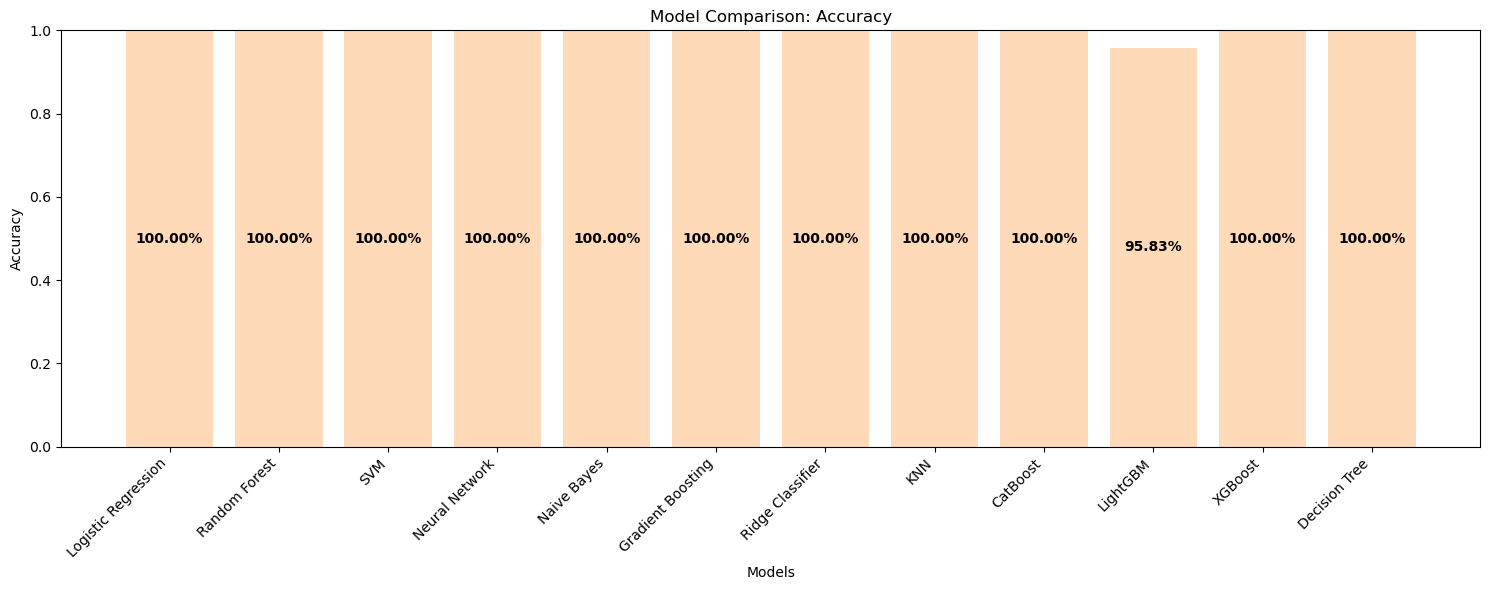

In [61]:
# List of model names and their corresponding accuracies
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Neural Network', 'Naive Bayes', 'Gradient Boosting', 'Ridge Classifier', 'KNN', 'CatBoost', 'LightGBM', 'XGBoost', 'Decision Tree']
accuracies = [accuracy_lr, accuracy_rf, accuracy_svm, accuracy_nn,  nb_test_accuracy, gb_test_accuracy, accuracy_ridge, accuracy_knn, accuracy_catboost, accuracy_lgb, accuracy_xgb, accuracy_dt]

# Create a bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(model_names, accuracies, color='PeachPuff')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy')
plt.ylim(0, 1.0)  # Set the y-axis limit to ensure readability

# Display accuracy percentages inside the bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{acc:.2%}',
             ha='center', va='center', fontsize=10, fontweight='bold', color='black')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Confusion matrix as heatmap

In [62]:
# Define a function to plot confusion matrix as heatmap
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

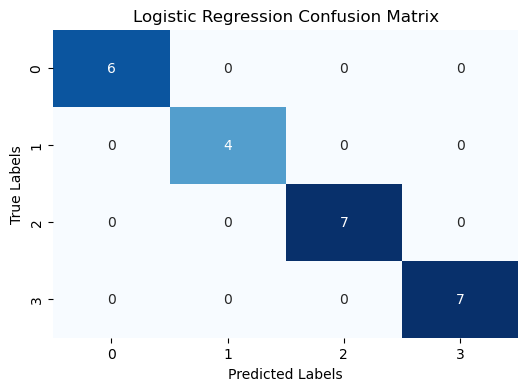

In [63]:
# Plot confusion matrices for each model
plot_confusion_matrix(conf_matrix_lr, 'Logistic Regression Confusion Matrix')

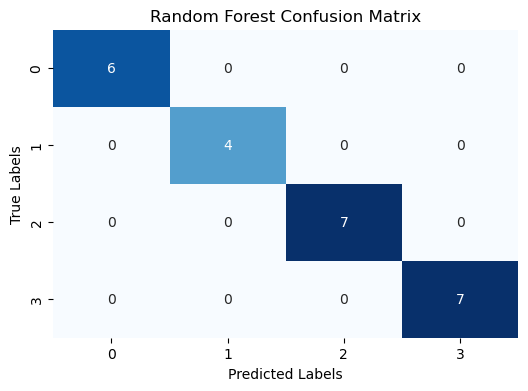

In [64]:
plot_confusion_matrix(conf_matrix_rf, 'Random Forest Confusion Matrix')

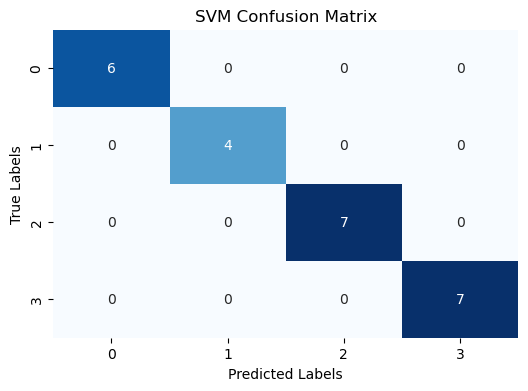

In [65]:
plot_confusion_matrix(conf_matrix_svm, 'SVM Confusion Matrix')

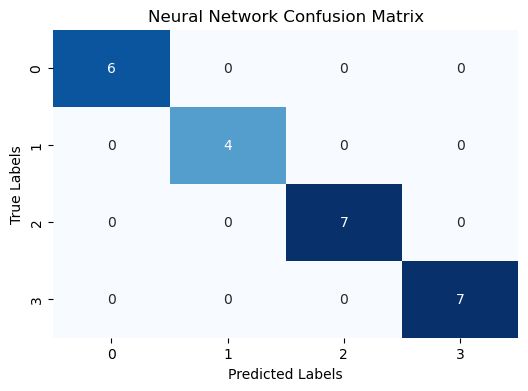

In [66]:
plot_confusion_matrix(conf_matrix_nn, 'Neural Network Confusion Matrix')

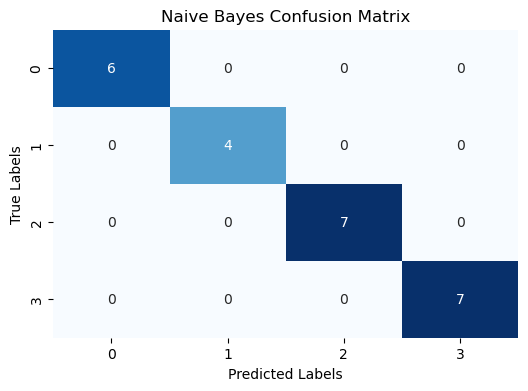

In [67]:
plot_confusion_matrix(nb_conf_matrix, 'Naive Bayes Confusion Matrix')

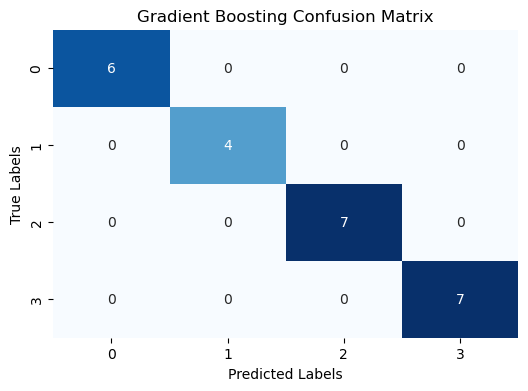

In [68]:
plot_confusion_matrix(gb_conf_matrix, 'Gradient Boosting Confusion Matrix')

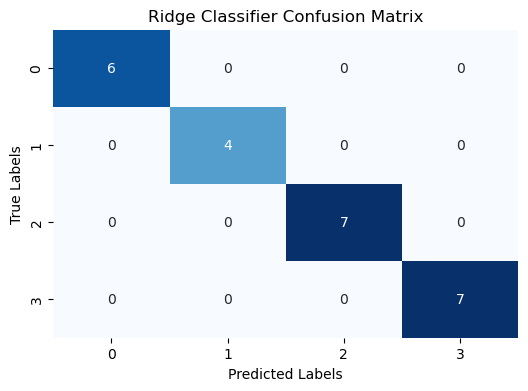

In [69]:
plot_confusion_matrix(conf_matrix_ridge, 'Ridge Classifier Confusion Matrix')

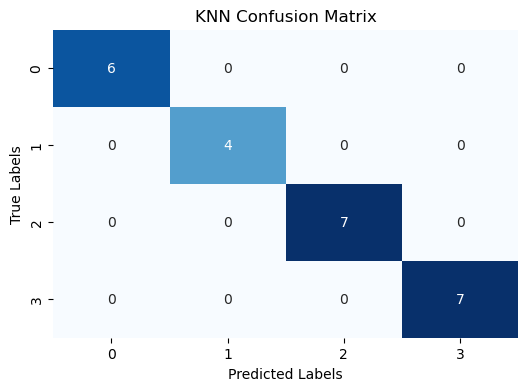

In [70]:
# Plot confusion matrices for each model
plot_confusion_matrix(conf_matrix_knn, 'KNN Confusion Matrix')

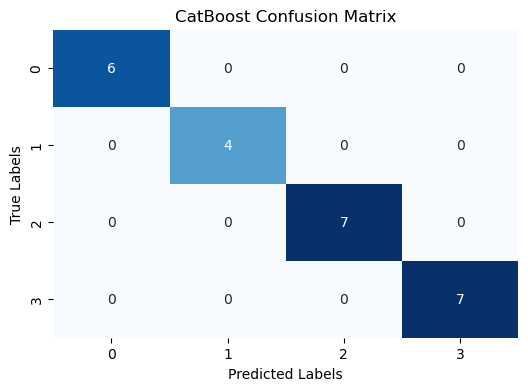

In [71]:
# Plot confusion matrices for each model
plot_confusion_matrix(conf_matrix_catboost, 'CatBoost Confusion Matrix')

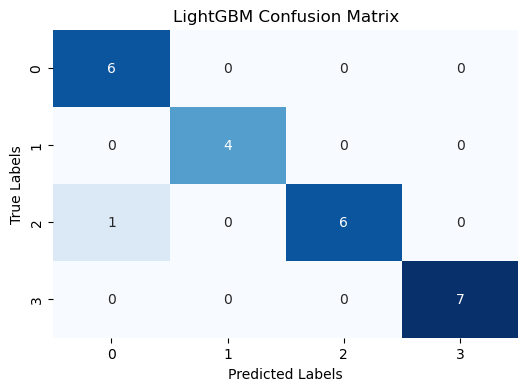

In [72]:
# Plot confusion matrices for each model
plot_confusion_matrix(conf_matrix_lgb, 'LightGBM Confusion Matrix')

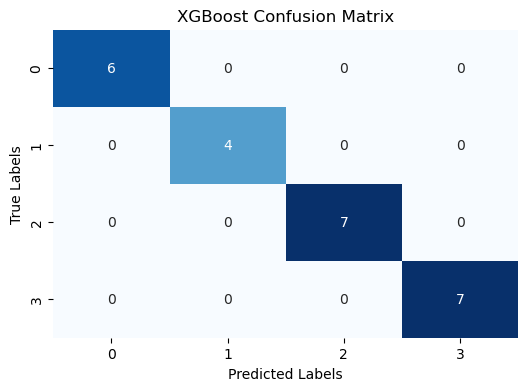

In [73]:
# Plot confusion matrices for each model
plot_confusion_matrix(conf_matrix_xgb, 'XGBoost Confusion Matrix')

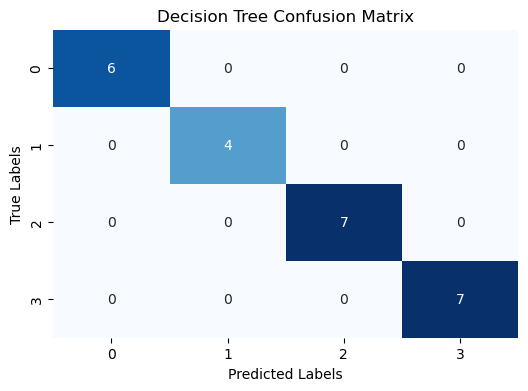

In [74]:
# Plot confusion matrices for each model
plot_confusion_matrix(conf_matrix_dt, 'Decision Tree Confusion Matrix')

In [76]:
import pickle

In [77]:
# Save the TF-IDF vectorizer as a pickle file
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(word_vectorizer, file)

In [78]:
# Create a Pickle file using serialization
import pickle
pickle_out= open("xgb_classifier.pkl", "wb")
pickle.dump(xgb_classifier, pickle_out)
pickle_out.close()